<h1 style="color:orange">EXERCISE CLASS 4</h1>

# Theory Recap

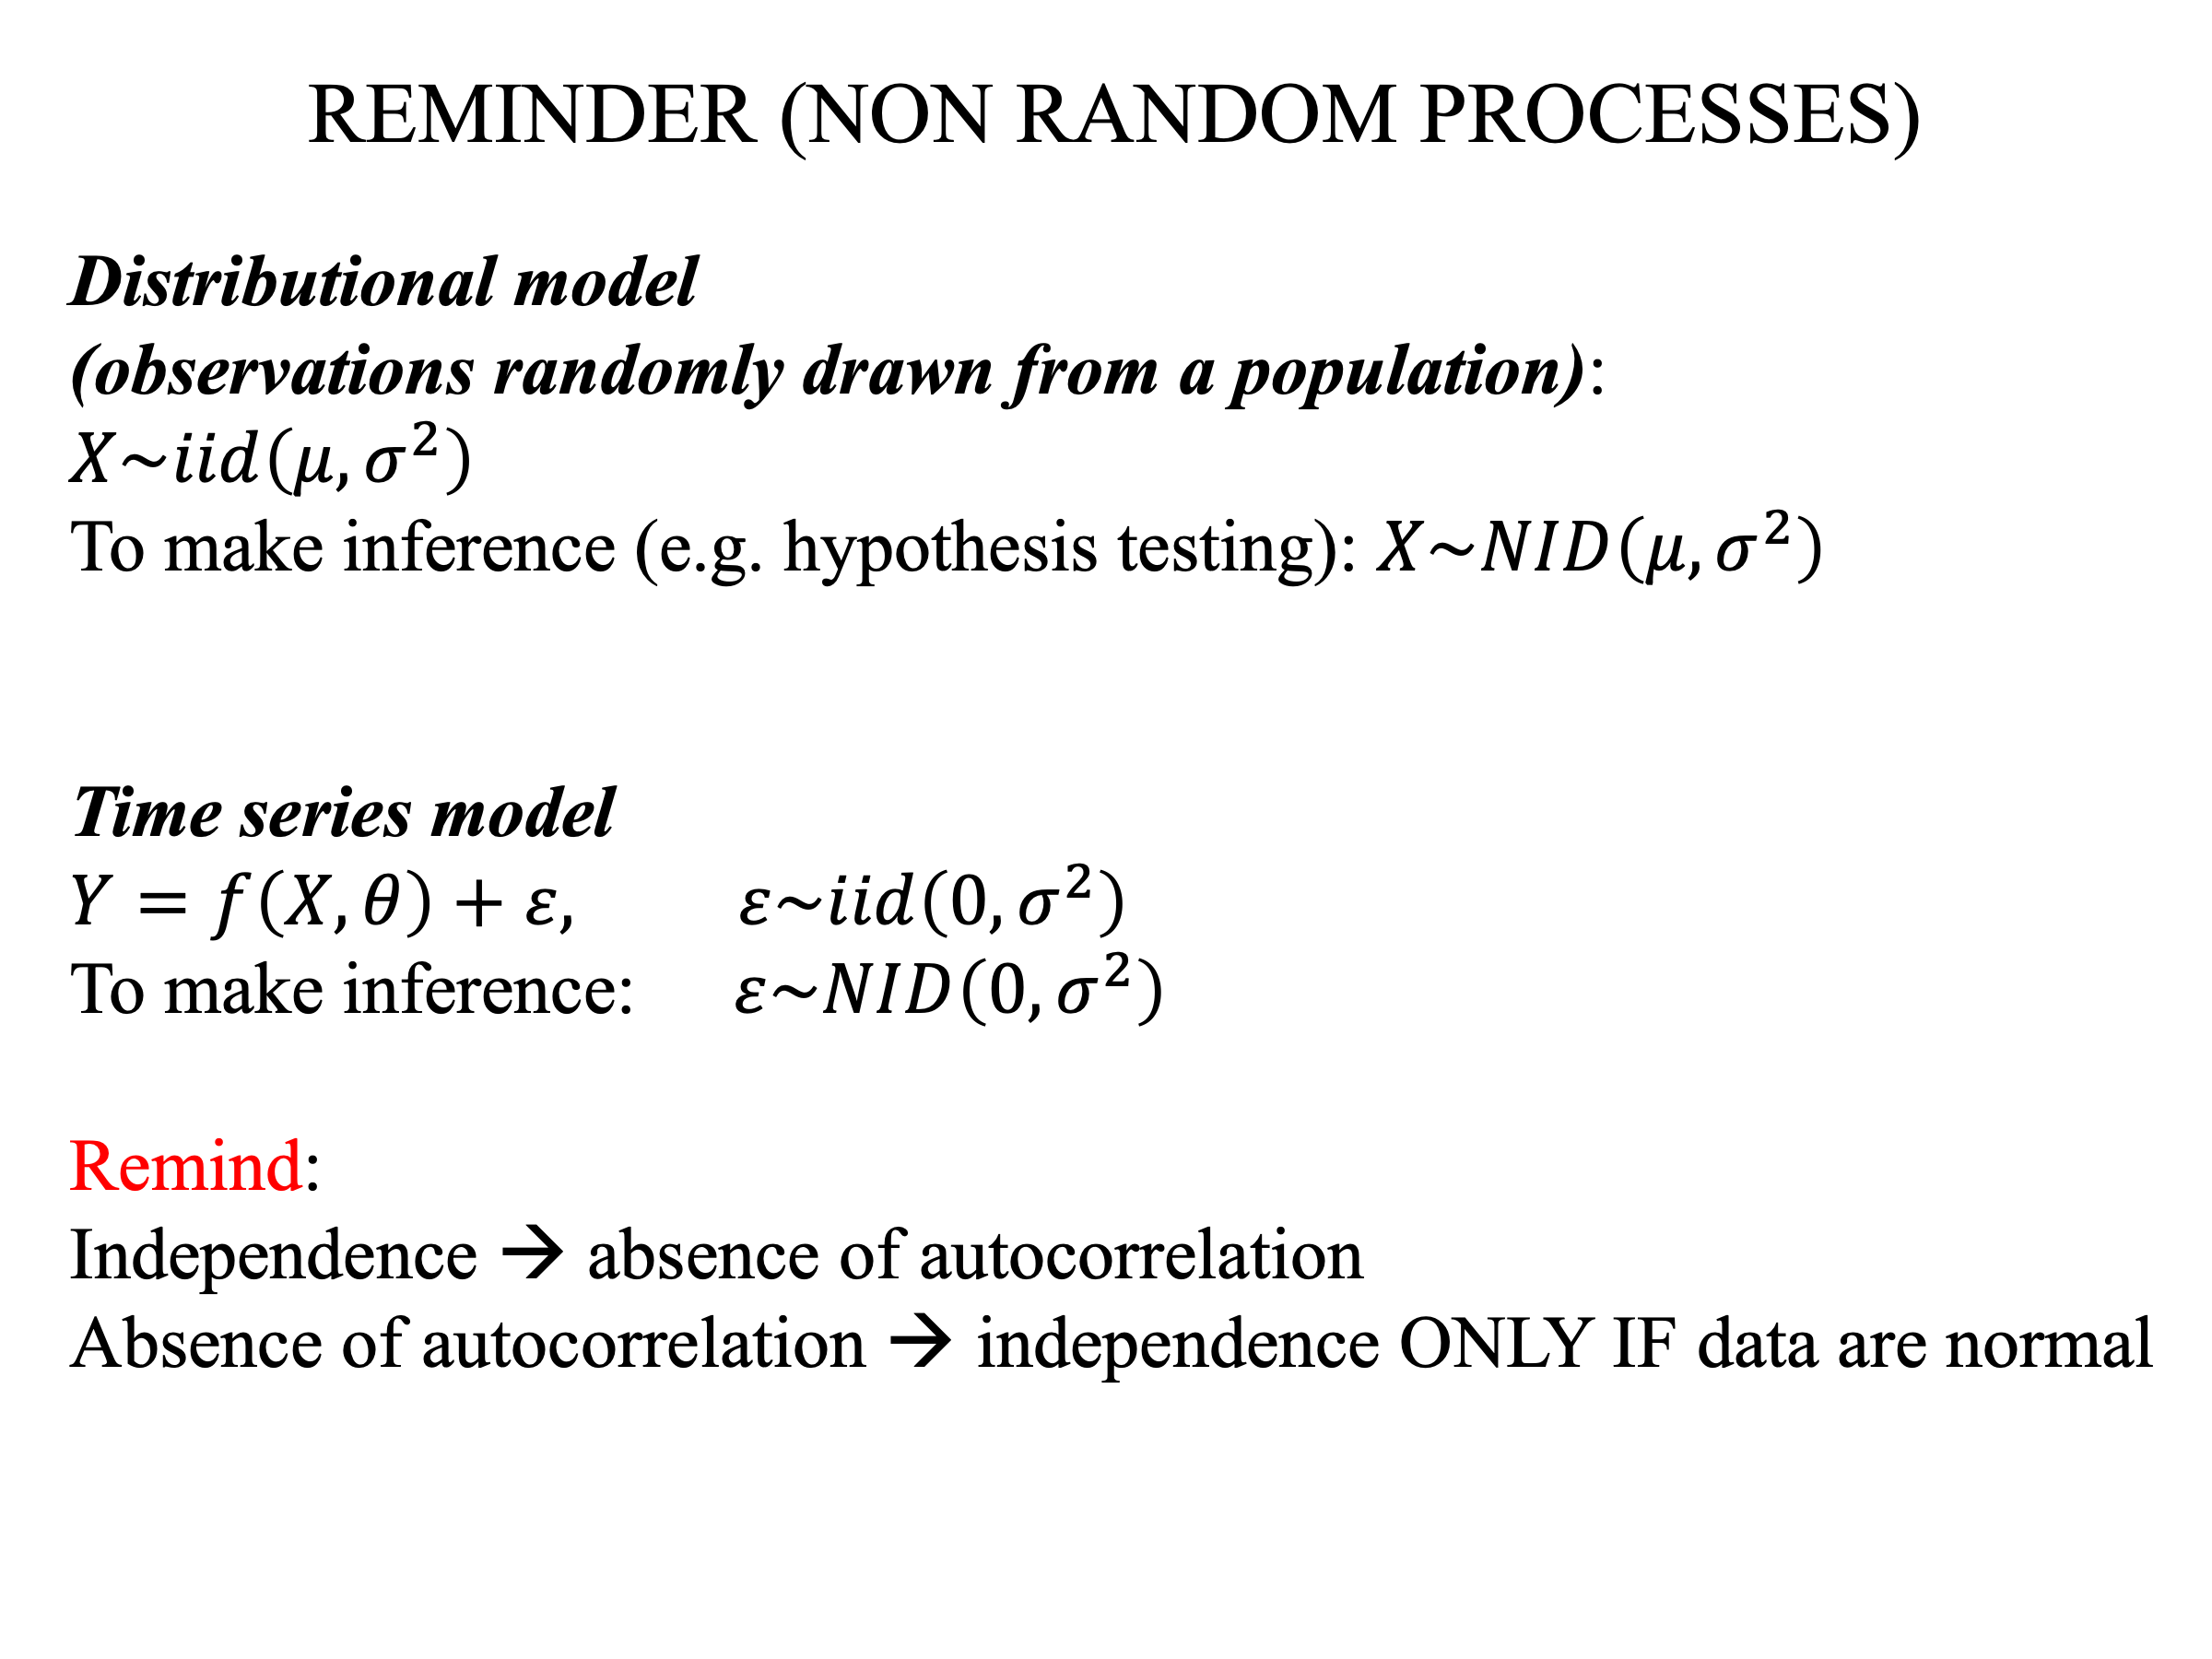
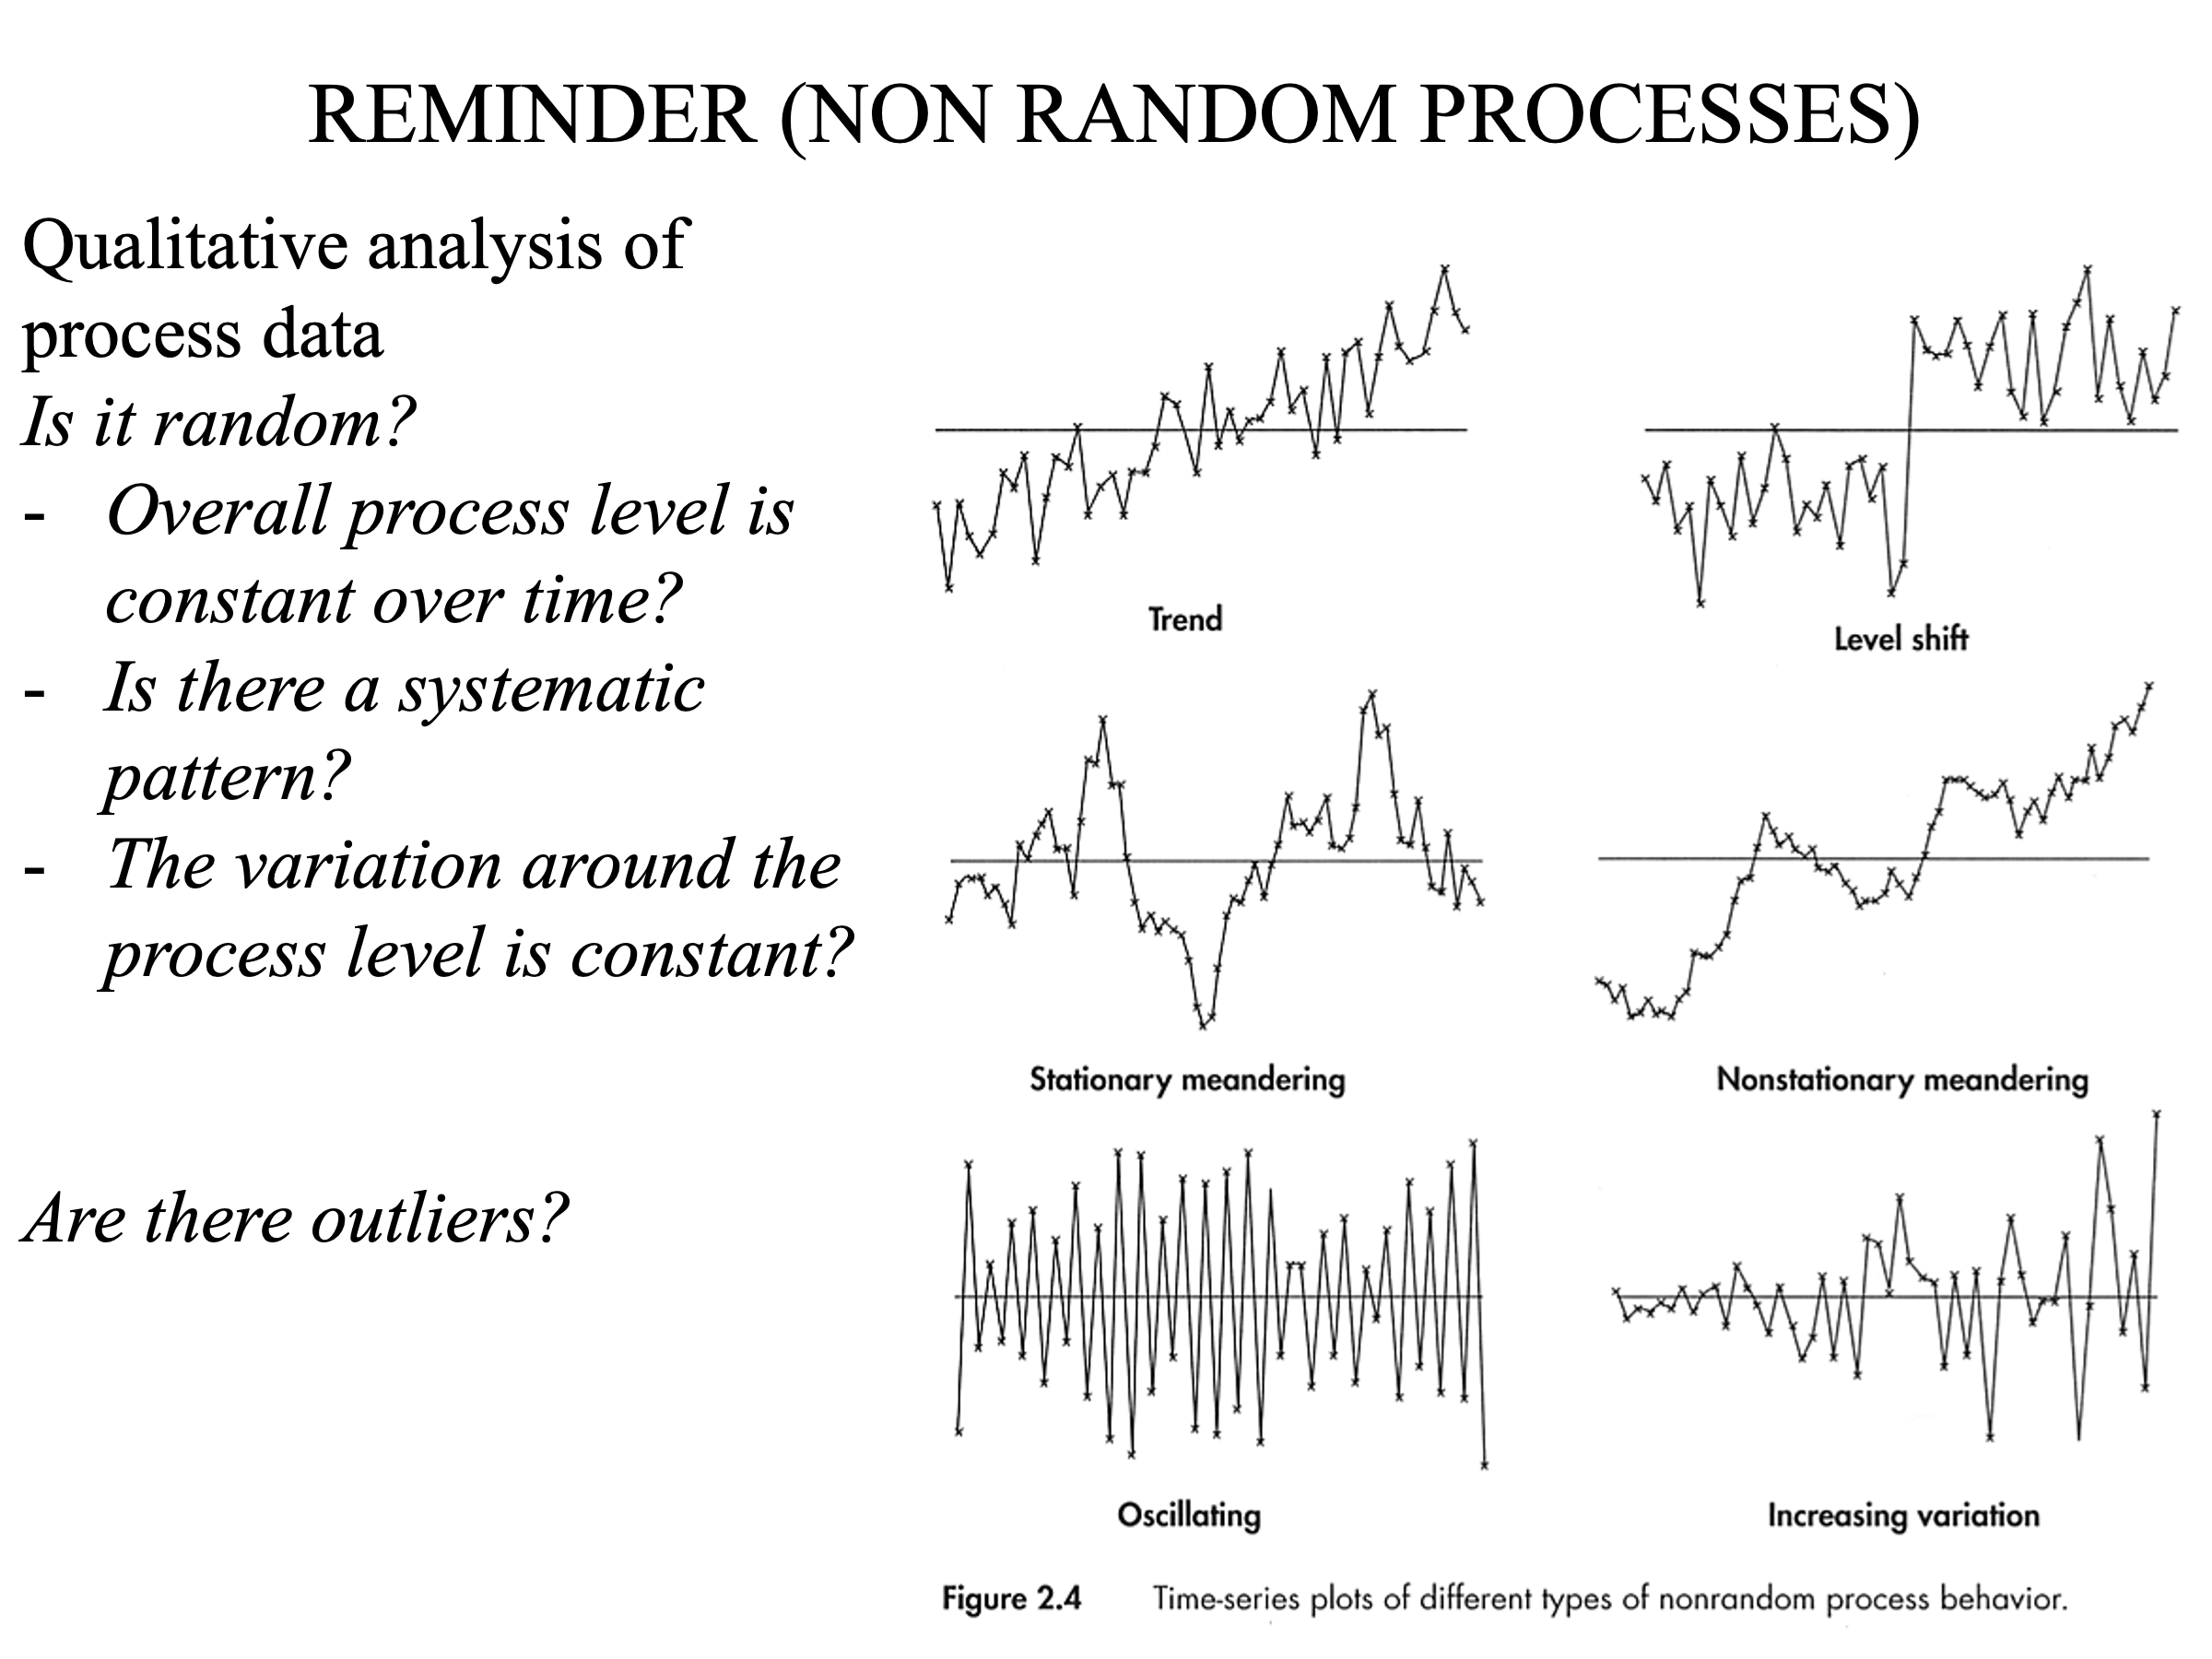

# Exercise 1

In a chemical process it is necessary to keep constant the pH of a compound. Measurements are made every hour. Data acquired over the first 48 hours are reported in `ESE4_ex1.csv`.

Identify and fit a model for the data.

<t1 style="color:red"> In a future class:  
Design a SCC control chart and a FVC control chart  

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_ex1.csv')

# Inspect the dataset
data.head()

EXE1
0  8.67
1  8.65
2  8.64
3  8.67
4  8.74

> ### Solution
>
> Let's first check if:
> - The data are random.
> - (If random) The data are normally distributed.

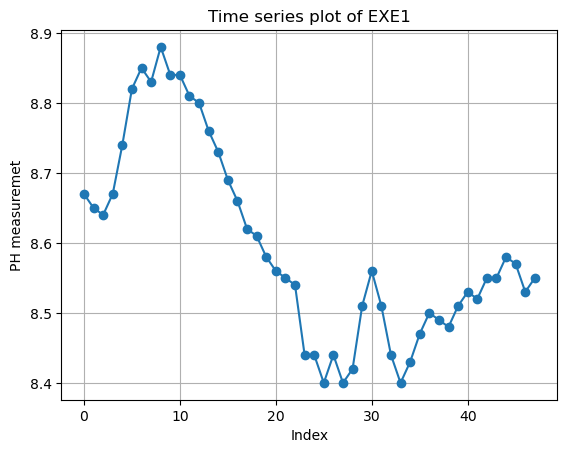

In [2]:
# Plot the data first
plt.plot(data['EXE1'], 'o-')
plt.xlabel('Index')
plt.ylabel('PH measuremet')
plt.title('Time series plot of EXE1')
plt.grid()
plt.show()

In [3]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['EXE1'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

Runs test p-value = 0.000


> The runs test gives a null p-value, this means that the data are <span style="color:red"> not random </span>. 
>
> Plot also the autocorrelation and partial autocorrelation functions of the data. Use the `plot_acf` and `plot_pacf` functions from the `statsmodels` package.

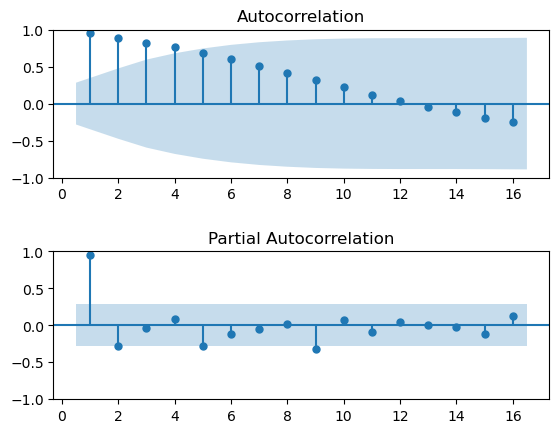

In [4]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['EXE1'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['EXE1'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> There is a strong positive correlation. Decay of autocorrelation coefficients is not exponential.
> Based on ACF analysis, we can state that the process is non-stationary
>
> We can observe with a scatterplot the correlation between $X(t)$ and $X(t-1)$.

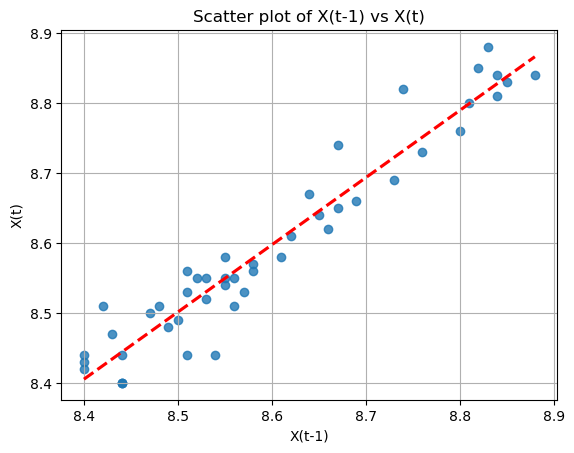

In [5]:
#calculate the lag1 from data
data['lag1'] = data['EXE1'].shift(1)

#create scatterplot with regression line using seaborn and set axis labels
sns.regplot(x=data['lag1'], y=data['EXE1'], ci=None, line_kws={'color':'red', 'ls':'--'})
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.xlabel('X(t-1)')
plt.ylabel('X(t)')
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.grid()



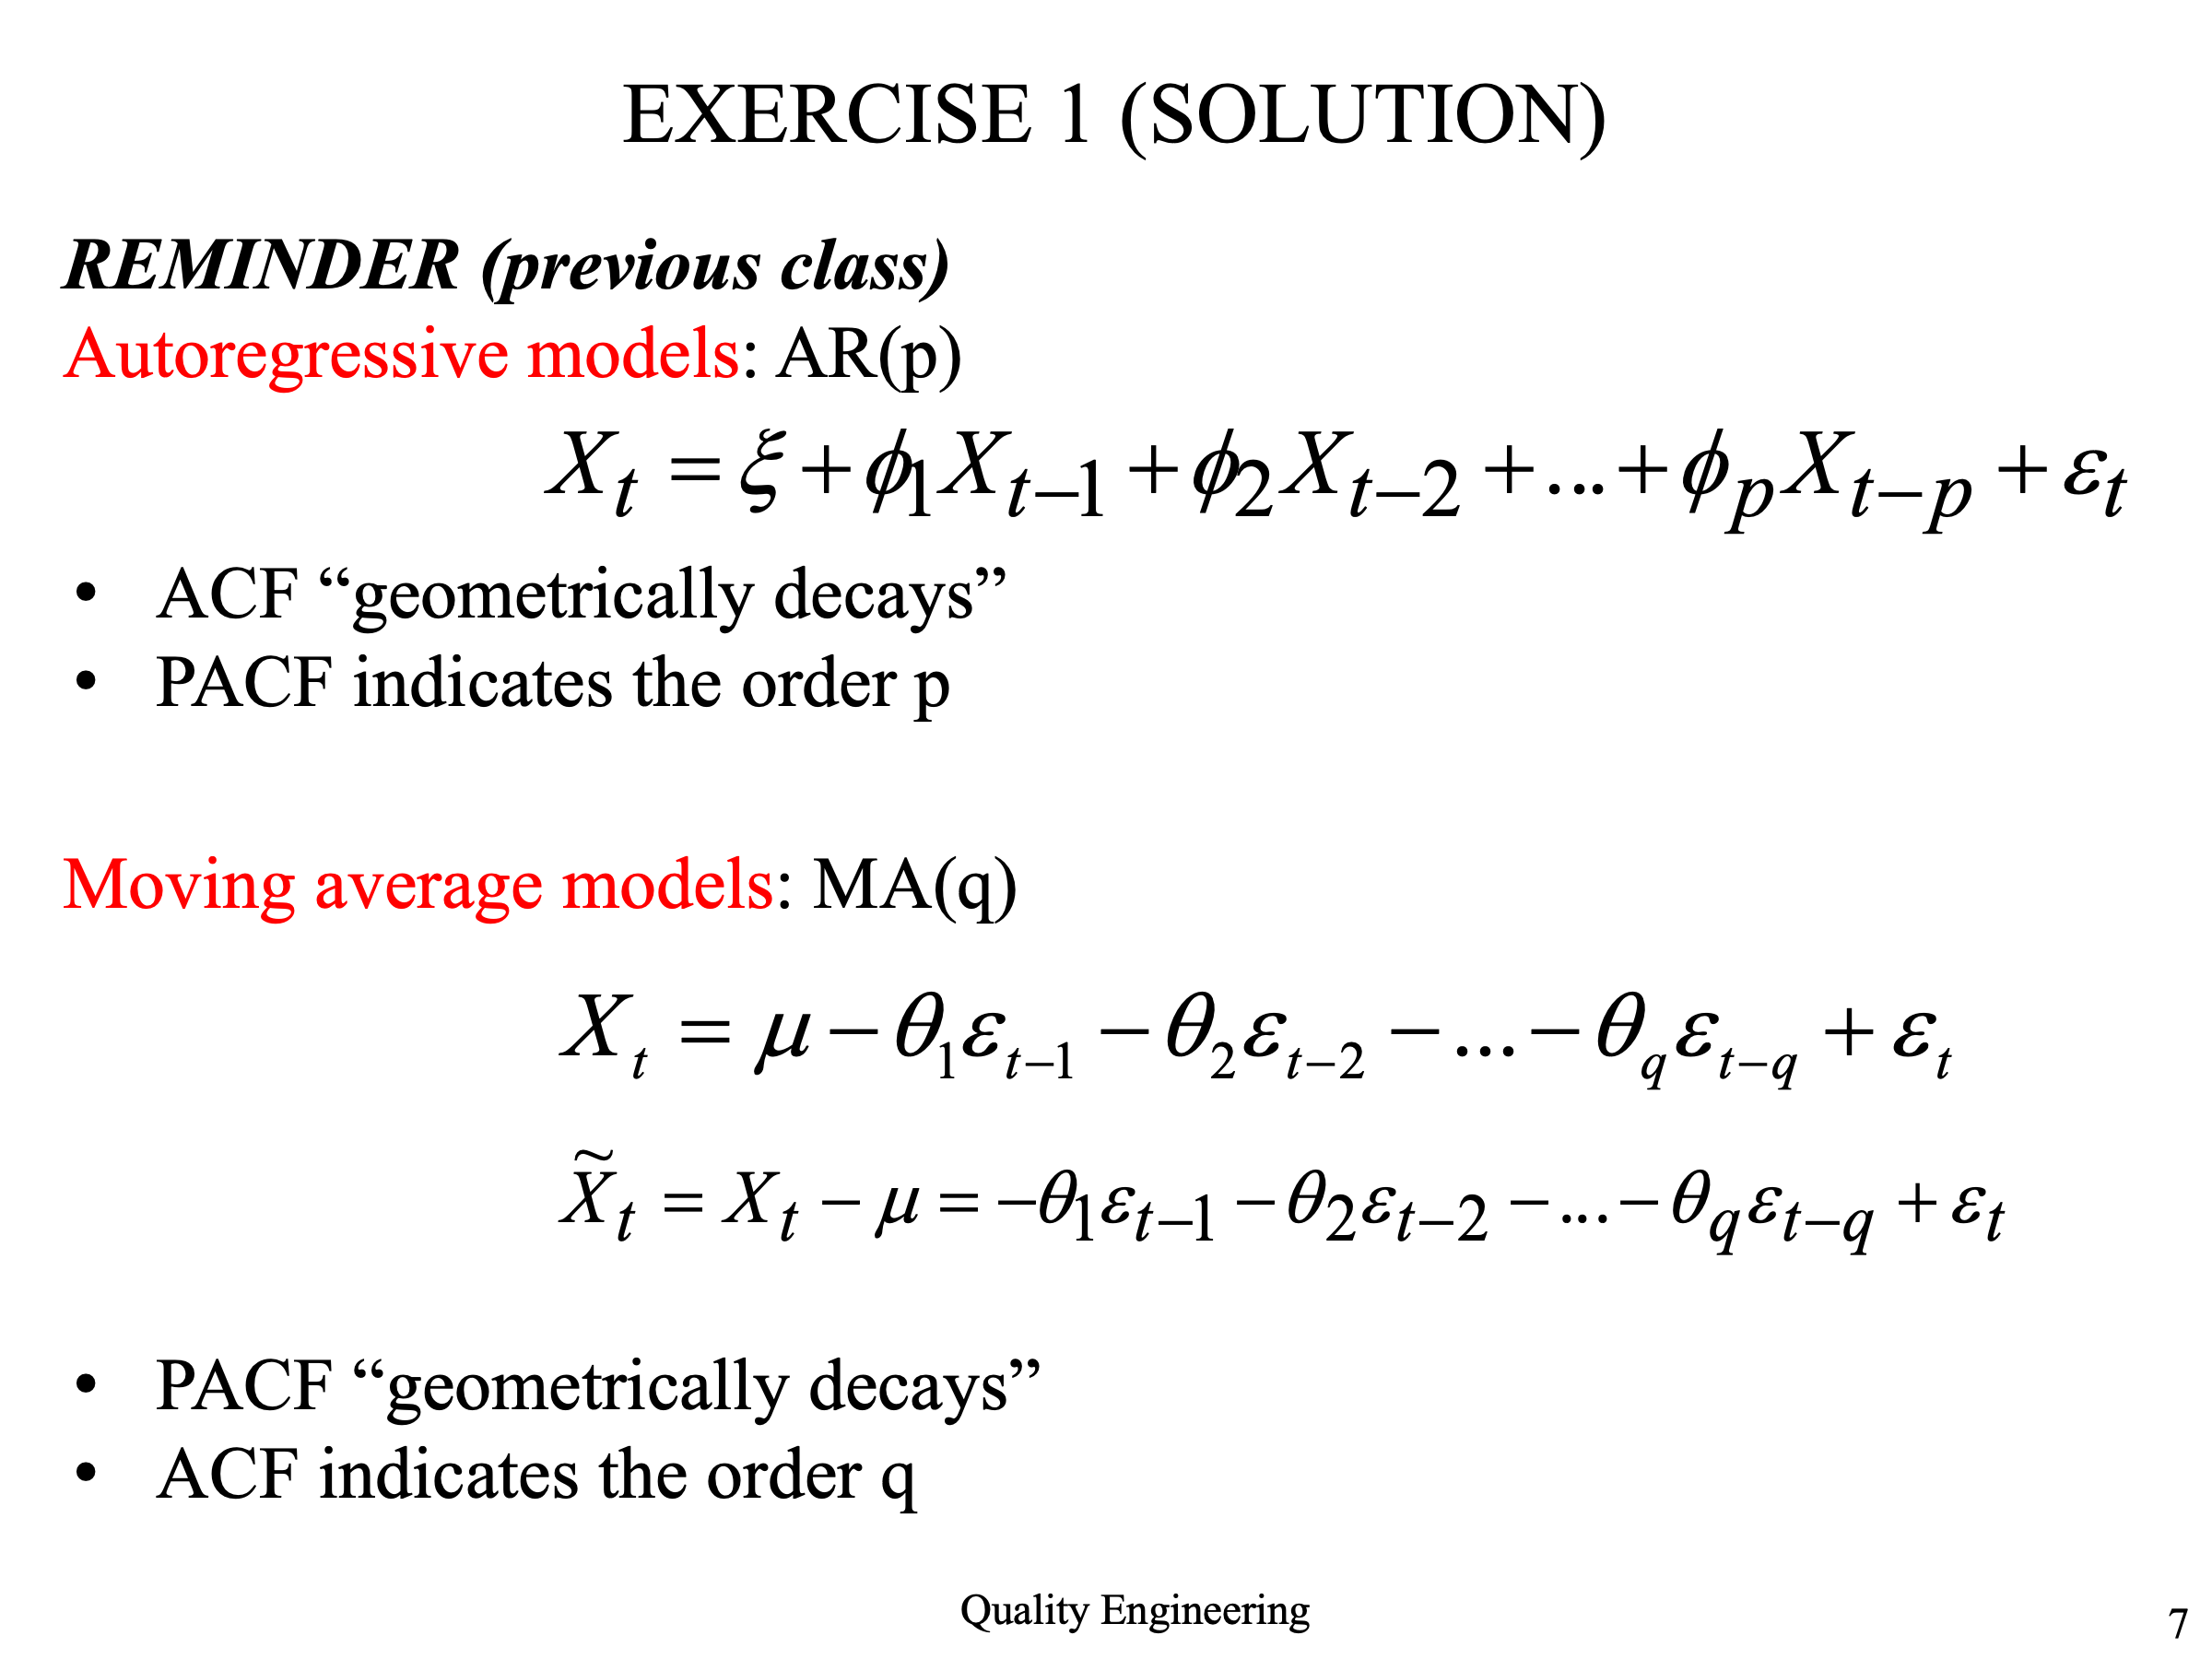
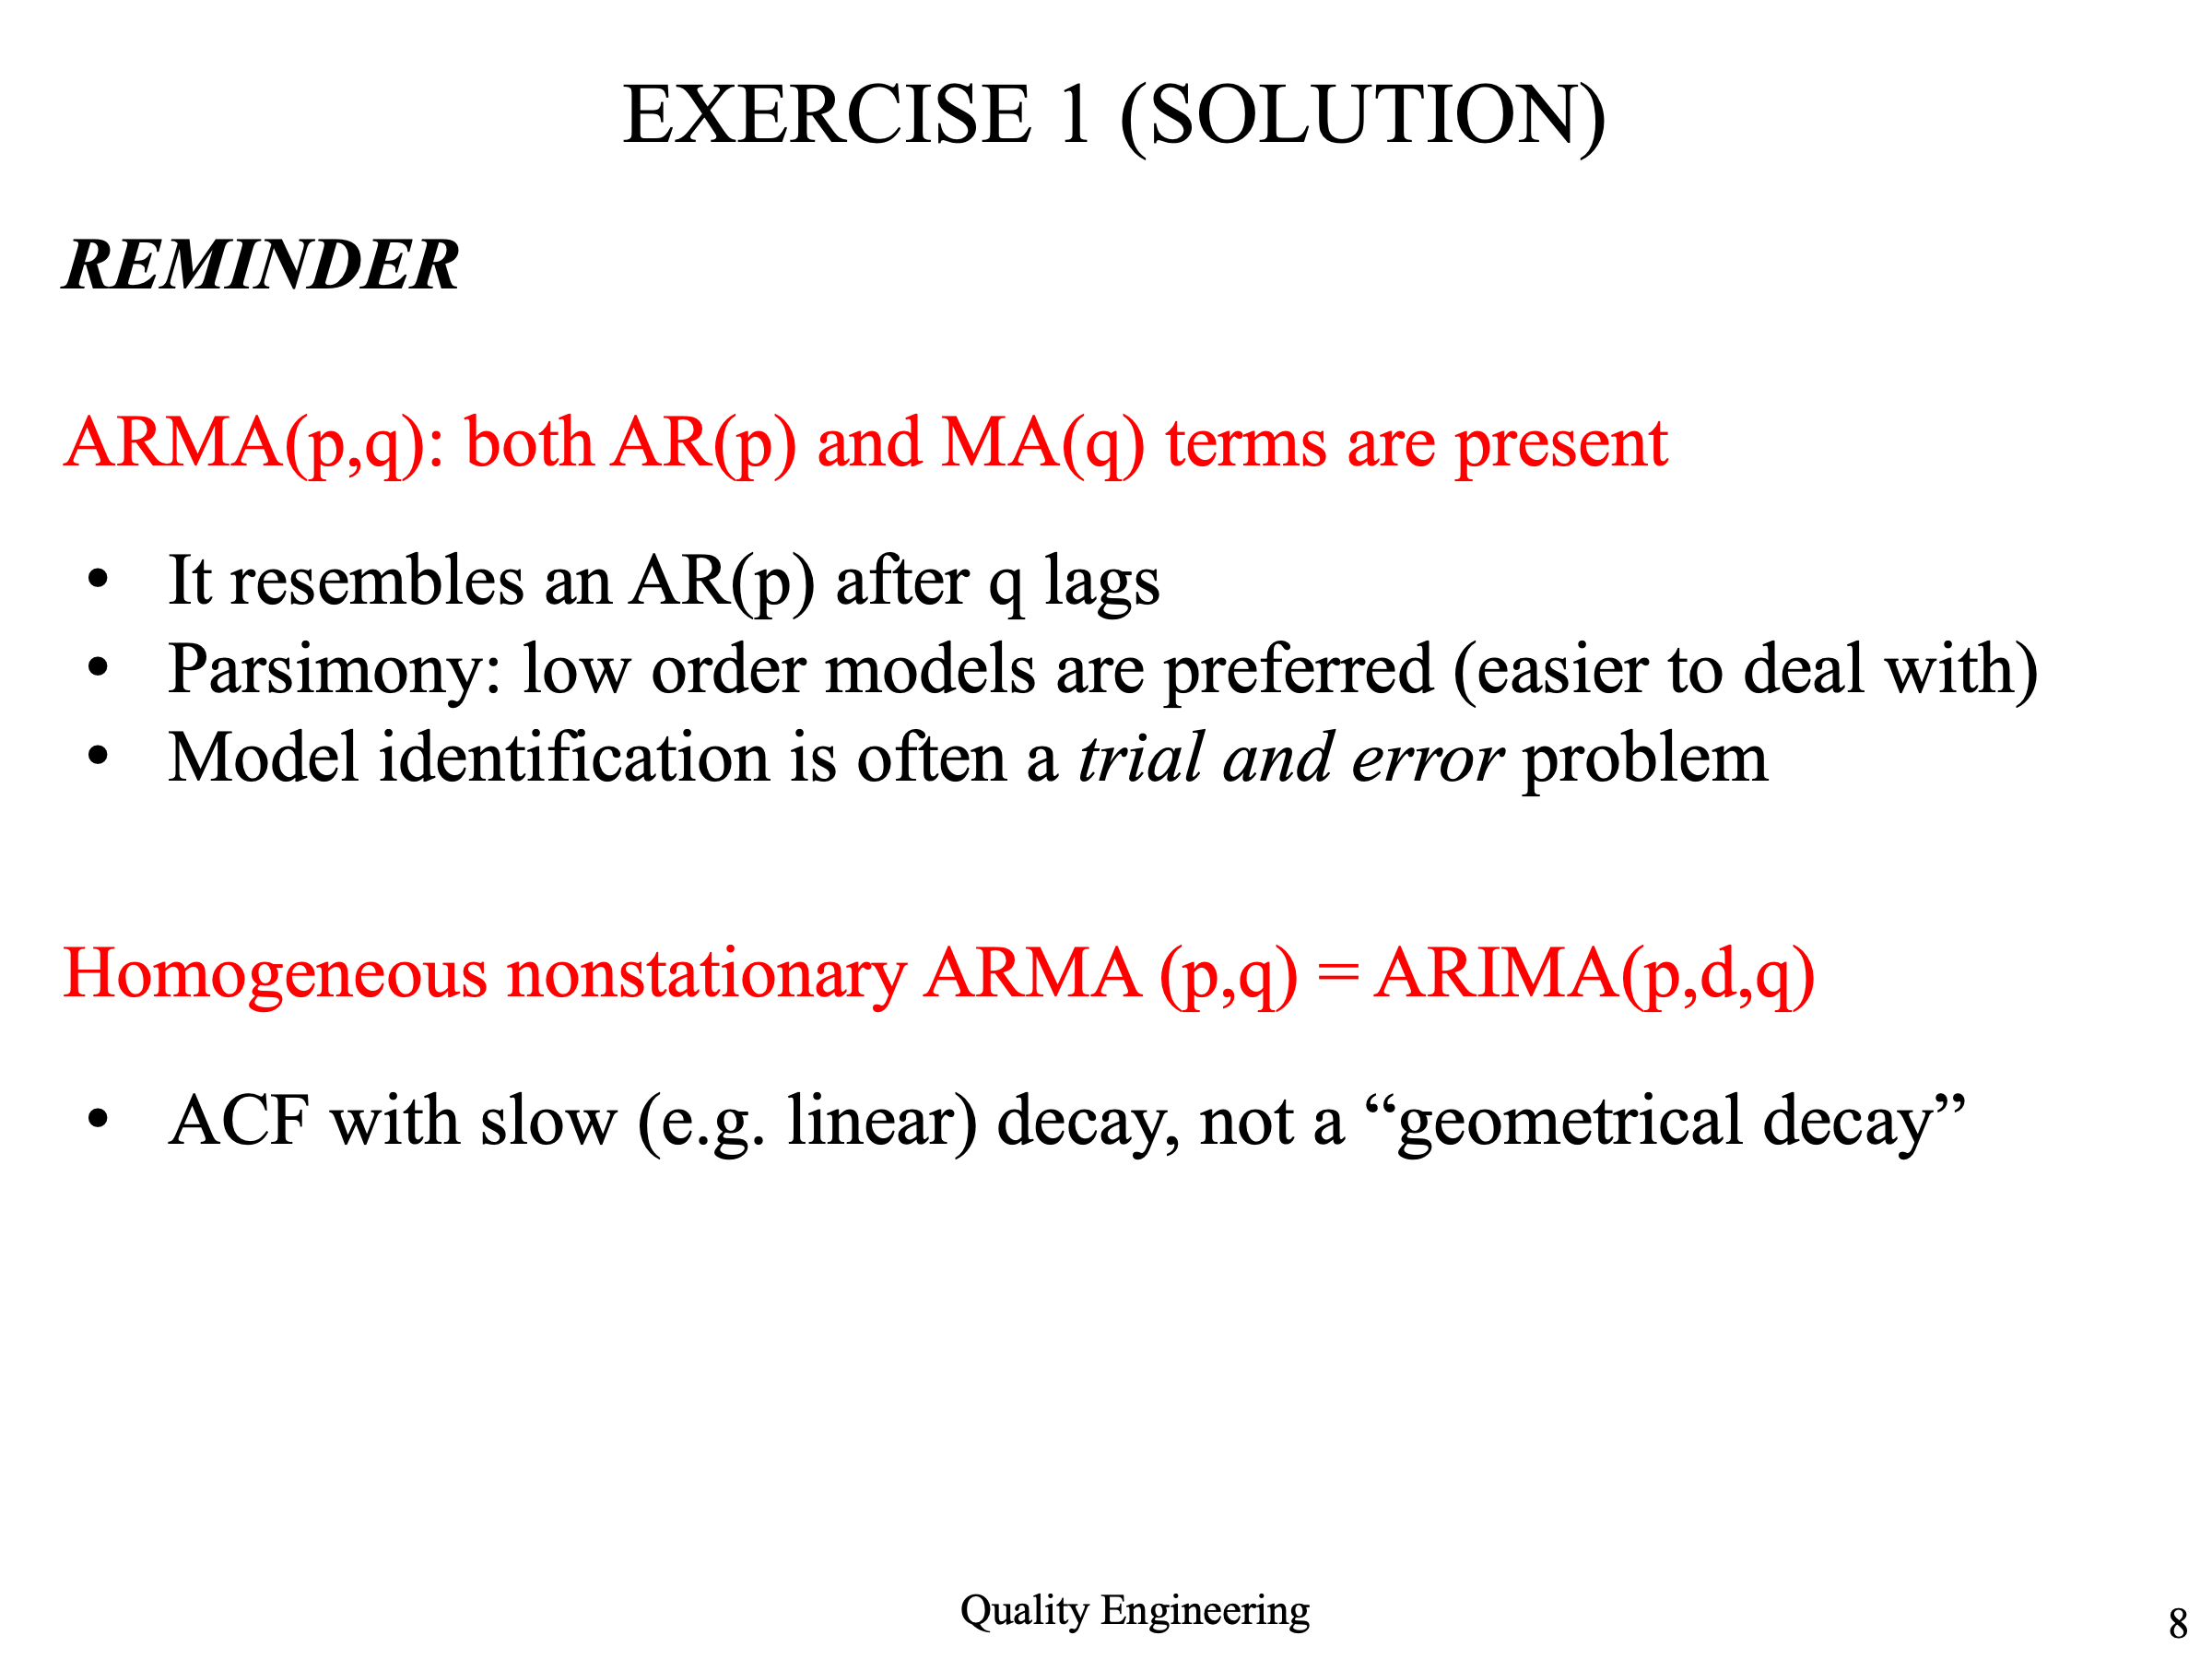
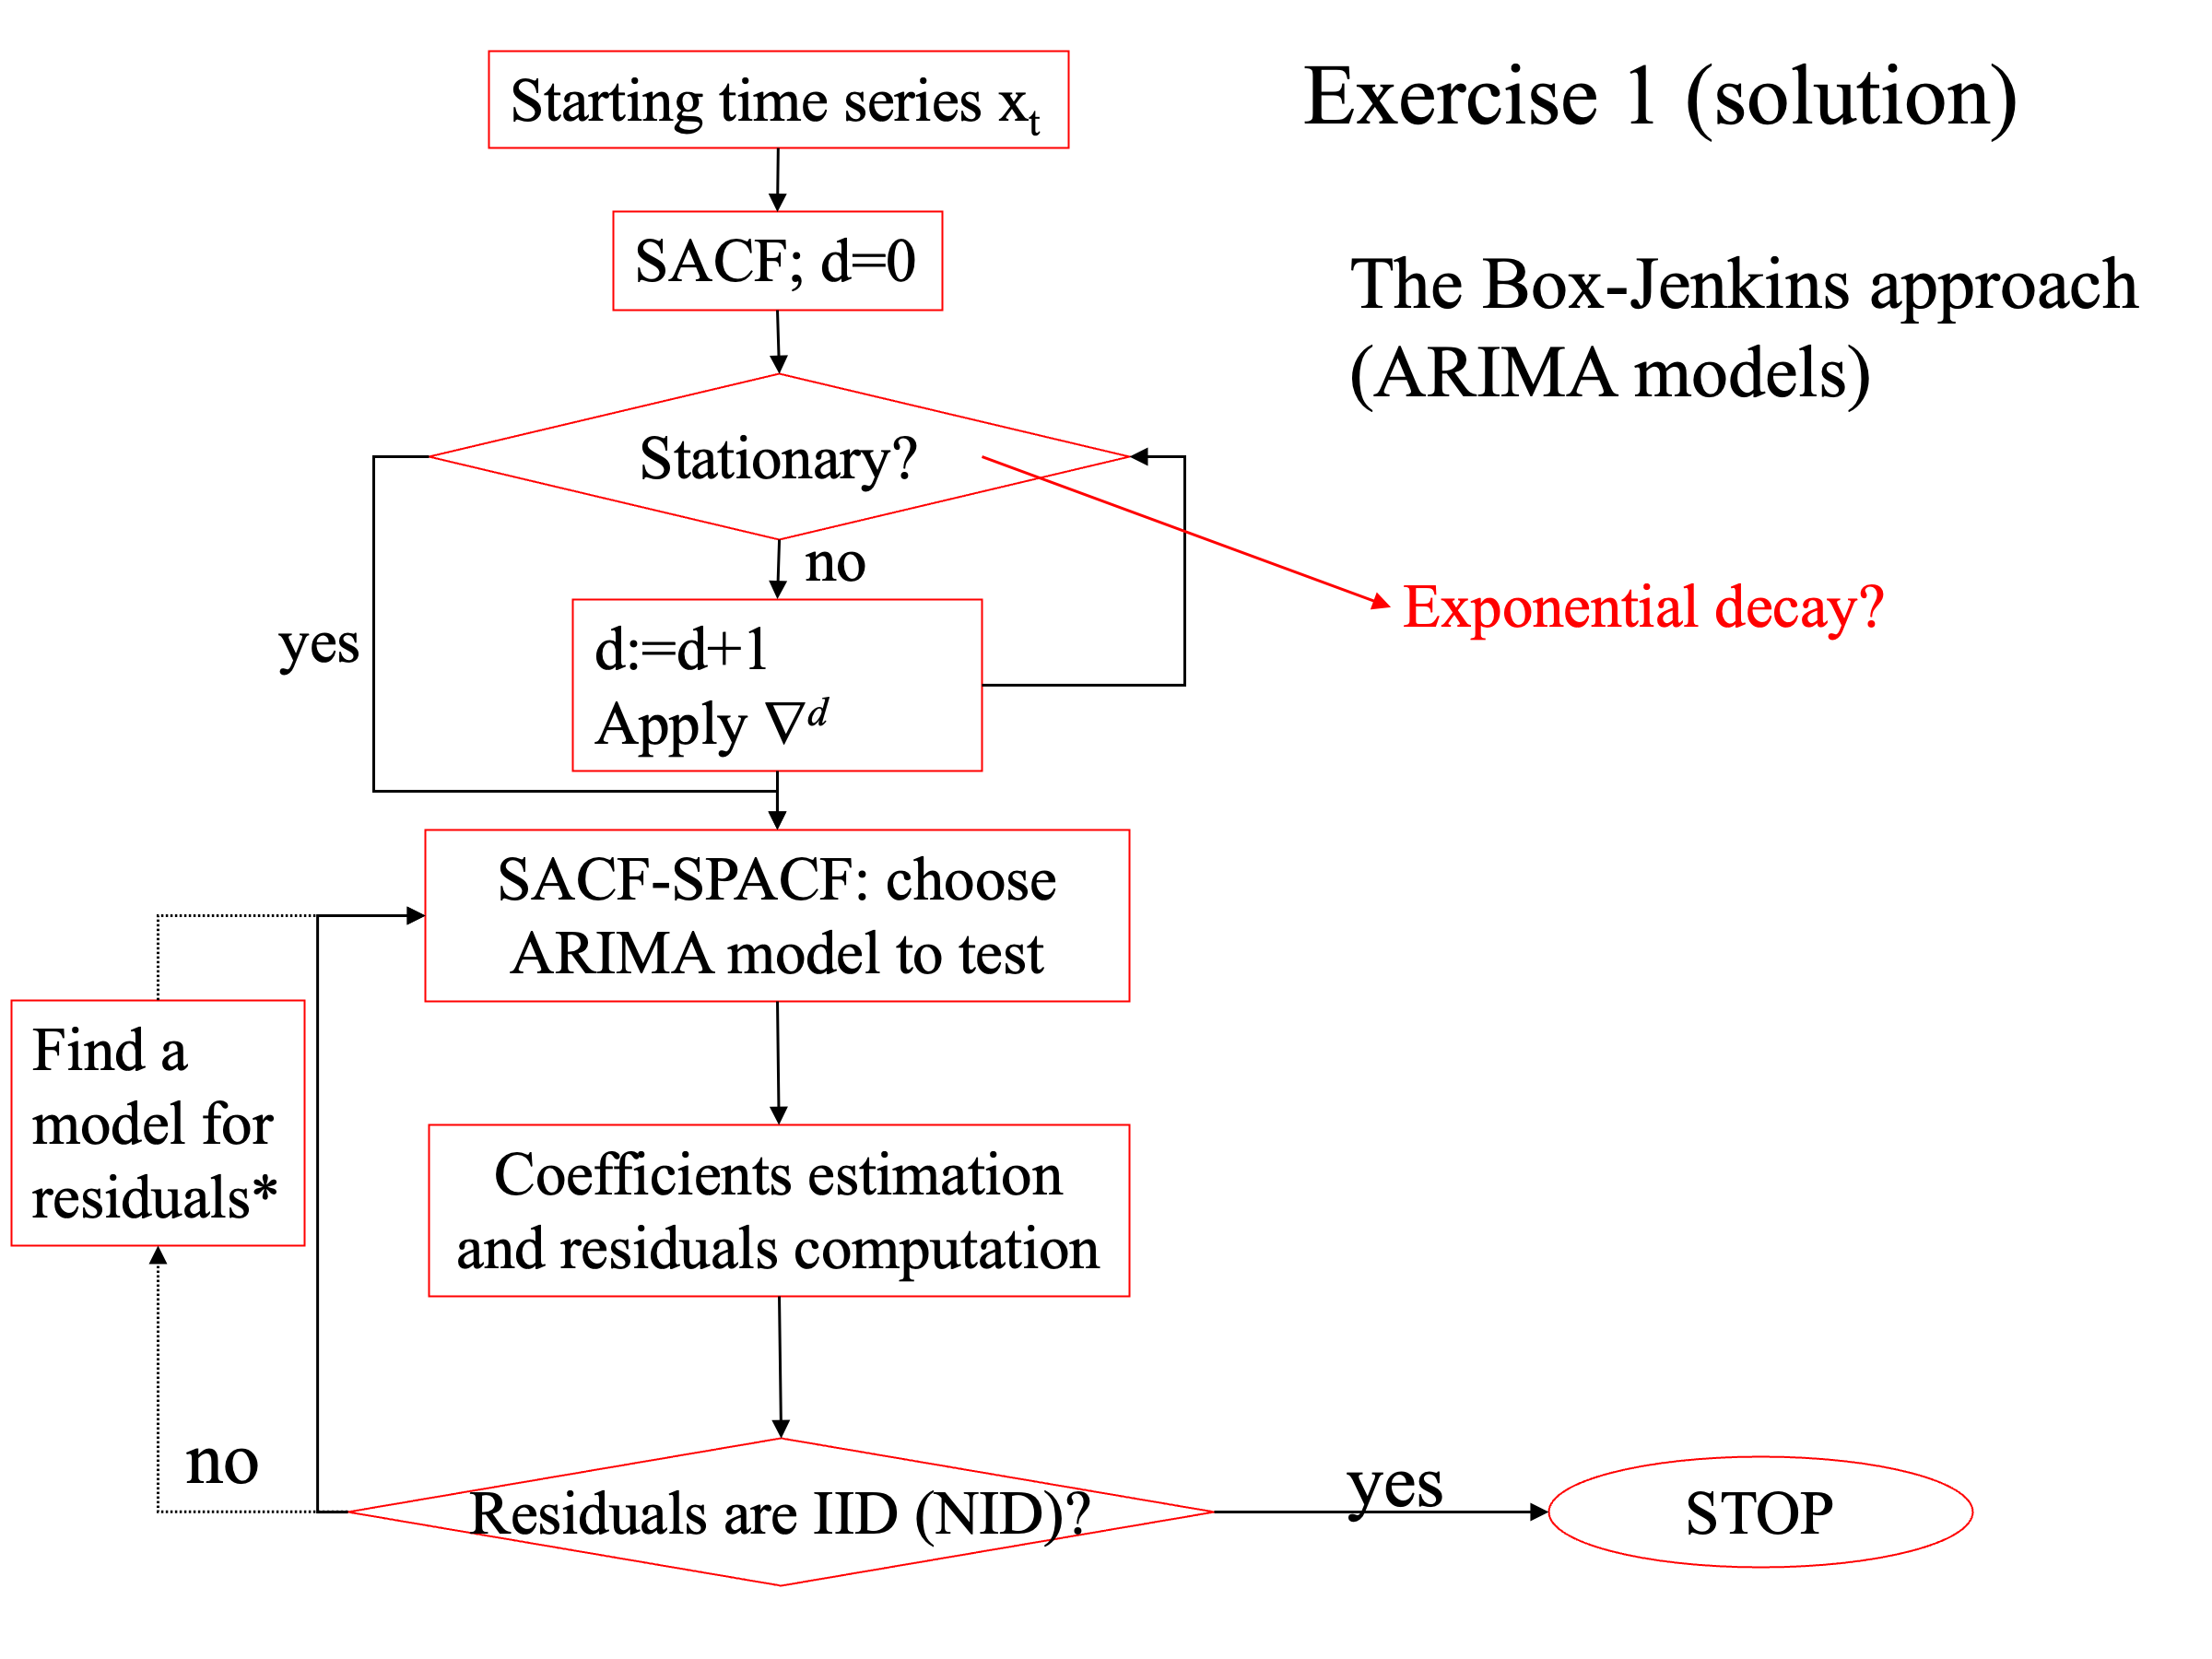

> Let's apply the time difference operator to our time serie data. This is done to check for stationarity of the mean value of the time series

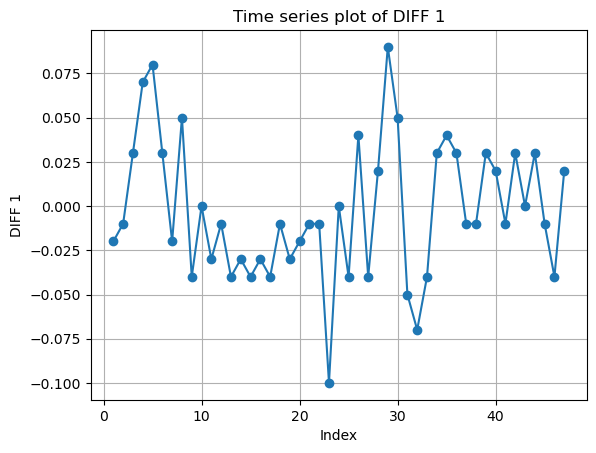

In [6]:
#calculate the difference between the data and the lag1
data['diff1'] = data['EXE1'] - data['lag1']

plt.plot(data['diff1'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF 1')
plt.title('Time series plot of DIFF 1')
plt.grid()
plt.show()

We got rid of the nonstationarity in the data, but we must check quantitatively what we said

> Let's check if differences at lag 1 are NID

In [7]:
#Let's calculate the p-value (exclude the first value because it is null)
_, pval_runs = runstest_1samp(data['diff1'][1:], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

Runs test p-value = 0.230


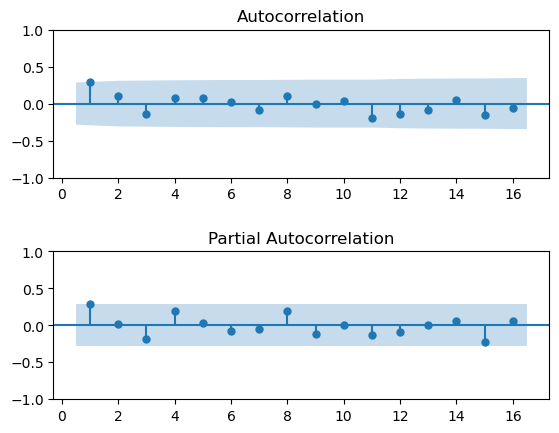

In [8]:
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()


In [9]:
from statsmodels.tsa.stattools import acf

n = len(data['diff1'][1:])

#autocorrelation function
[acf_values, lbq, _] = acf(data['diff1'][1:], nlags = int(np.sqrt(n)), qstat=True, fft = False)

#Bartlett's test at lag 1
alpha = 0.05
lag_test = 1
rk = acf_values[lag_test]
z_alpha2 = stats.norm.ppf(1-alpha/2)
print('Test statistic rk = %f' % rk)
print('Rejection region starts at %f' % (z_alpha2/np.sqrt(n)))

Test statistic rk = 0.288387
Rejection region starts at 0.285890


This is a typical borderline situation. At 95% confidence, we should reject the randomness assumption. In this case, we may proceed by fitting an `AR(1)` model on the transformed data by applying the difference operator, and check if residuals are NID. If residuals are NID, the resulting model would be an `ARIMA(1,1,0)`.
Another option is to accept the transformed data are barely random. If we follow this second path, we shall verify if they are also normal. Let's follow this second route (we'll see examples of `ARIMA(1,1,0)` models later on). 

We check if the diff1 data comes from a Normal distribution

Shapiro-Wilk test p-value = 0.188


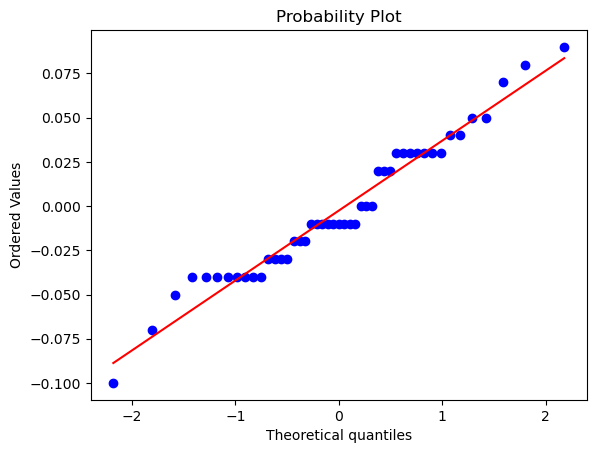

In [10]:
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(data['diff1'][1:])
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(data['diff1'][1:], dist="norm", plot=plt)
plt.show()

> The process is modeled as a <t1 style="color:red"> RANDOM WALK </t1>
>
> **Random Walk**:
> - $Y_{t} = Y_{t-1} + \epsilon_{t} $

## Point b
It is the best model? Is this the best one?
We can also try an AR(1) model directly on the original data (no application of the difference operator)


In [11]:
#calculate a regression model with constant and lag1
import statsmodels.api as sm
import qda

x = data['lag1'][1:]
x = sm.add_constant(data['lag1'][1:]) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data['EXE1'][1:]
model = sm.OLS(y, x).fit()

qda.summary(model)


REGRESSION EQUATION
-------------------
EXE1 =  + 0.344 const + 0.960 lag1

COEFFICIENTS
------------
 Term   Coef  SE Coef  T-Value    P-Value
const 0.3439   0.3510   0.9799 3.3238e-01
 lag1 0.9597   0.0408  23.5067 6.5730e-27

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0392 0.9247      0.923

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value    P-Value
Regression  1.0  0.8497  0.8497 552.5667 6.5730e-27
     const  1.0  0.0015  0.0015   0.9602 3.3238e-01
      lag1  1.0  0.8497  0.8497 552.5667 6.5730e-27
     Error 45.0  0.0692  0.0015      NaN        NaN
     Total 46.0  0.9189     NaN      NaN        NaN


> Note that the p-value of the constant term is 0.332. 
>
><t1 style="color:red"> Let's re-calculate the model removing the constant term </t1>

In [12]:
x = data['lag1'][1:]
y = data['EXE1'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
EXE1 =  + 1.000 lag1

COEFFICIENTS
------------
Term   Coef  SE Coef  T-Value     P-Value
lag1 0.9997   0.0007 1503.228 1.4733e-109

MODEL SUMMARY
-------------
     S  R-sq  R-sq(adj)
0.0392   1.0        1.0

ANALYSIS OF VARIANCE
---------------------
    Source   DF    Adj SS    Adj MS    F-Value     P-Value
Regression  1.0 3471.6382 3471.6382 2.2597e+06 1.4733e-109
      lag1  1.0 3471.6382 3471.6382 2.2597e+06 1.4733e-109
     Error 46.0    0.0707    0.0015        NaN         NaN
     Total 47.0 3471.7089       NaN        NaN         NaN


> <t1 style="color:red"> We have found again the random walk model! </t1>
>
> $$EXE1 = 0.9997 \cdot lag1$$
>
> Let's check assumptions on residuals:
> - Normality
> - Time independence

Shapiro-Wilk test p-value on the residuals = 0.192


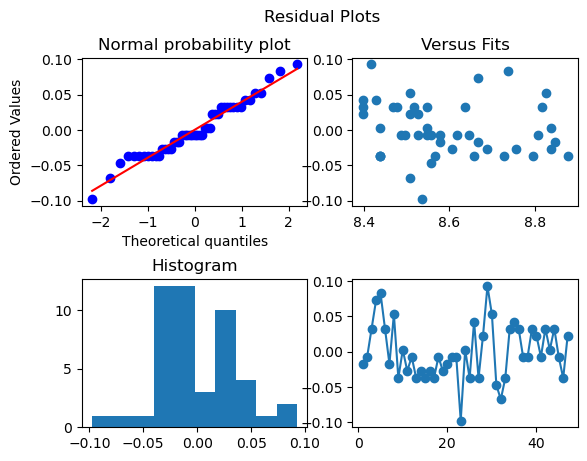

In [13]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

Runs test p-value on the residuals = 0.230


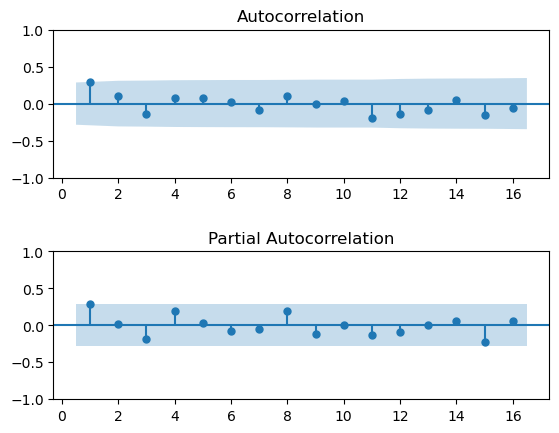

In [14]:
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

Let's check autocorrelation at lag 1 with Bartlett.
At 5% significance level:

In [15]:
from statsmodels.tsa.stattools import acf

#autocorrelation function
[acf_value, lbq, _] = acf(model.resid, nlags = int(len(model.resid)/3) , qstat=True)

#Bartlett's test at lag 1
lag_test=1
rk=abs(acf_value[lag_test])
alpha = 0.05 # significance level
z_alpha2 = stats.norm.ppf(1-alpha/2)
print('Test statistic rk = %f' % rk)
print('Rejection region starts at %f' % (z_alpha2/np.sqrt(len(model.resid))))


Test statistic rk = 0.288386
Rejection region starts at 0.285890


Same result as before (indeed the model is the same, i.e., random walk)
The Bartlett's null hypothesis is barely rejected at 95% confidence but not rejected at 99% confidence.  

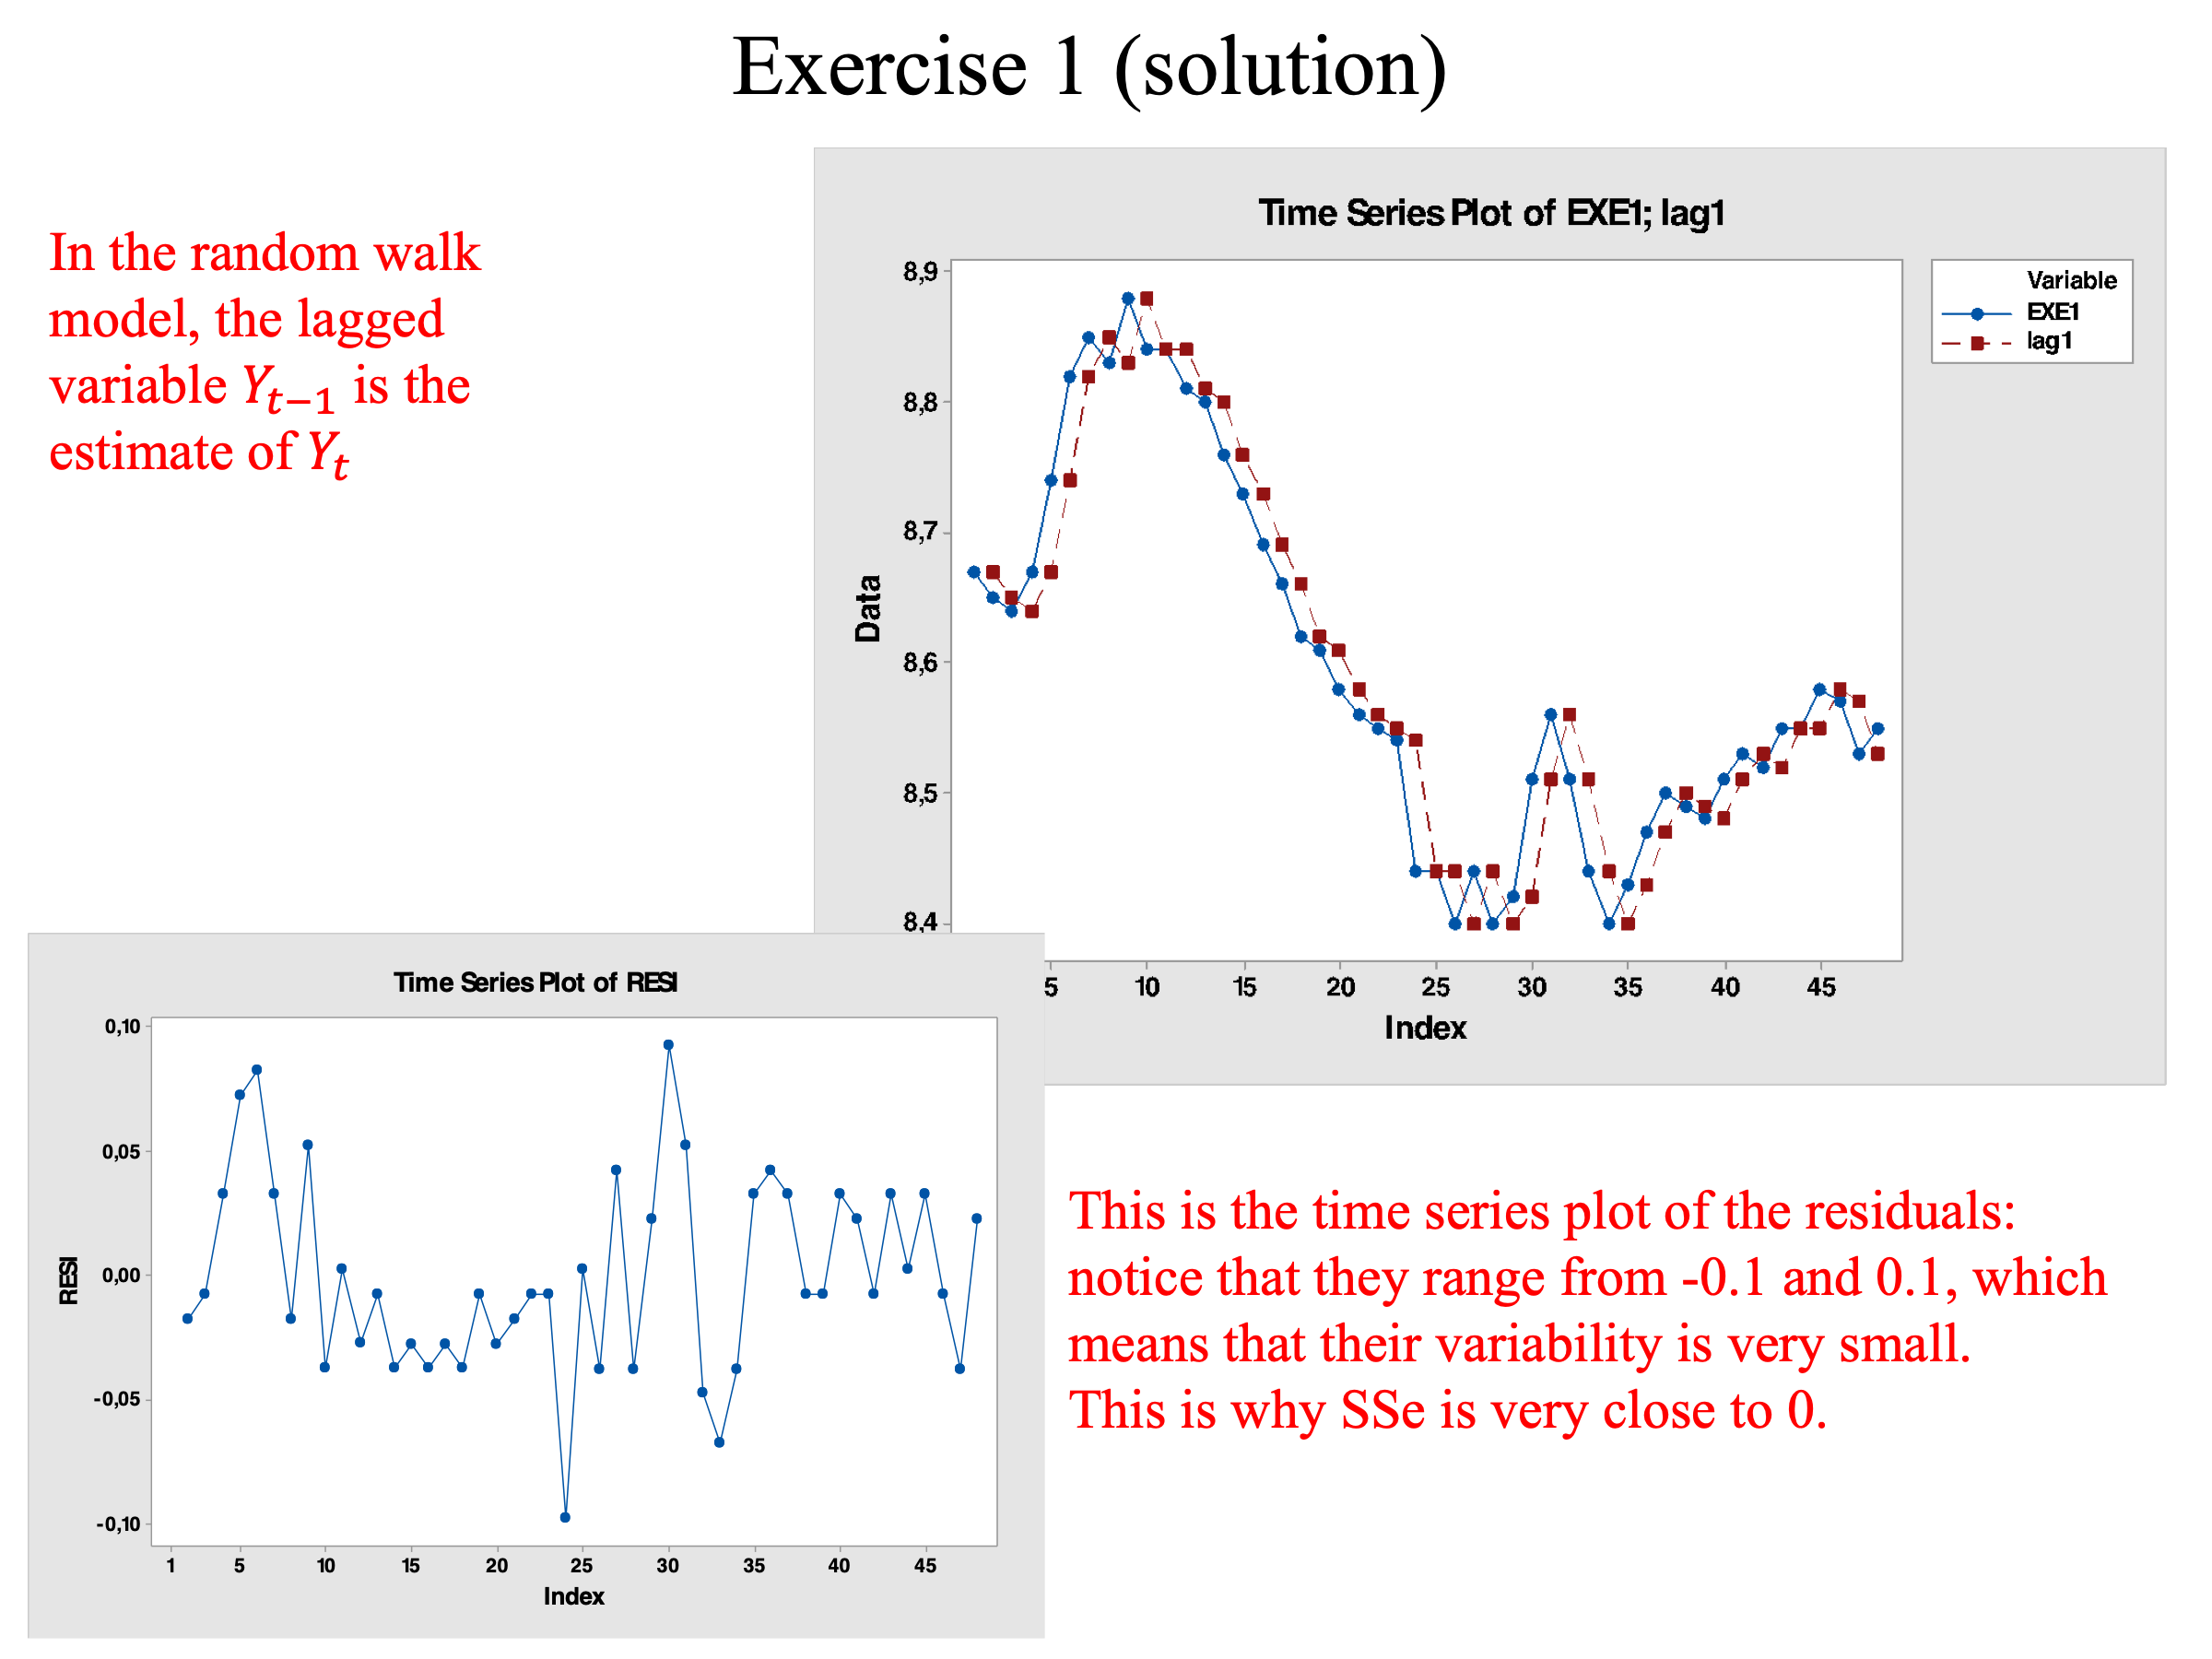

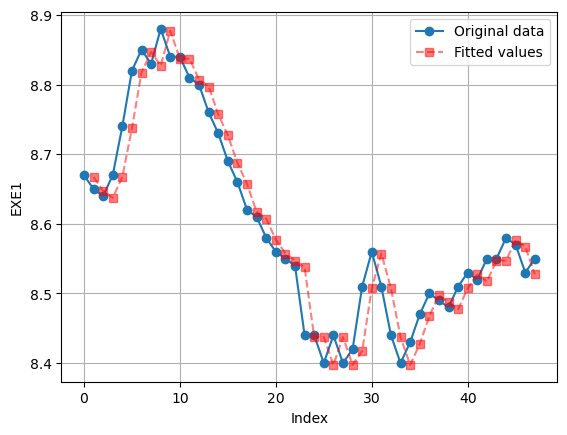

In [16]:
plt.plot(data['EXE1'], 'o-', label='Original data')
plt.xlabel('Index') 
plt.ylabel('EXE1')
plt.plot(model.fittedvalues, 's--', color='red', label='Fitted values', alpha=0.5)
plt.legend()
plt.grid()
plt.show()

## Try at home
Try to fit an ARIMA(1,1,0) on this time series and verify if the model is appropriate or not

In [17]:
data['diff1_lag1'] = data['diff1'].shift(1)

In [18]:
x = data['diff1_lag1'][2:]
x = sm.add_constant(x) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data['diff1'][2:]
model = sm.OLS(y, x).fit()

qda.summary(model)

REGRESSION EQUATION
-------------------
diff1 =  -0.001 const + 0.291 diff1_lag1

COEFFICIENTS
------------
      Term    Coef  SE Coef  T-Value  P-Value
     const -0.0013   0.0057  -0.2278   0.8209
diff1_lag1  0.2906   0.1445   2.0116   0.0504

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0383 0.0842     0.0634

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value  P-Value
Regression  1.0 5.9279e-03 5.9279e-03   4.0467   0.0504
     const  1.0 7.6009e-05 7.6009e-05   0.0519   0.8209
diff1_lag1  1.0 5.9279e-03 5.9279e-03   4.0467   0.0504
     Error 44.0 6.4455e-02 1.4649e-03      NaN      NaN
     Total 45.0 7.0383e-02        NaN      NaN      NaN


In [19]:
x = data['diff1_lag1'][2:]
y = data['diff1'][2:]
model = sm.OLS(y, x).fit()

qda.summary(model)

REGRESSION EQUATION
-------------------
diff1 =  + 0.293 diff1_lag1

COEFFICIENTS
------------
      Term   Coef  SE Coef  T-Value  P-Value
diff1_lag1 0.2932   0.1425   2.0573   0.0455

MODEL SUMMARY
-------------
     S  R-sq  R-sq(adj)
0.0378 0.086     0.0657

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value  P-Value
Regression  1.0  0.0061  0.0061   4.2324   0.0455
diff1_lag1  1.0  0.0061  0.0061   4.2324   0.0455
     Error 45.0  0.0645  0.0014      NaN      NaN
     Total 46.0  0.0706     NaN      NaN      NaN


Runs test p-value on the residuals = 0.514


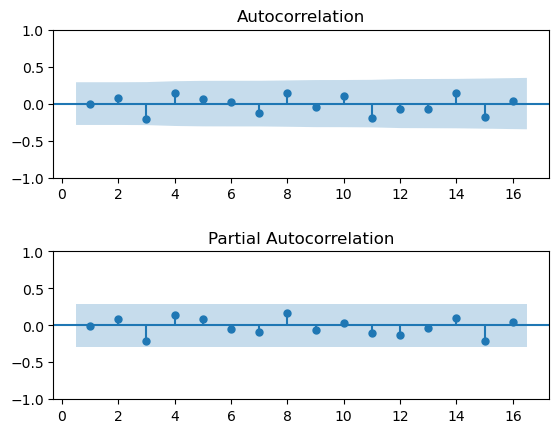

In [20]:
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

Shapiro-Wilk test p-value = 0.867


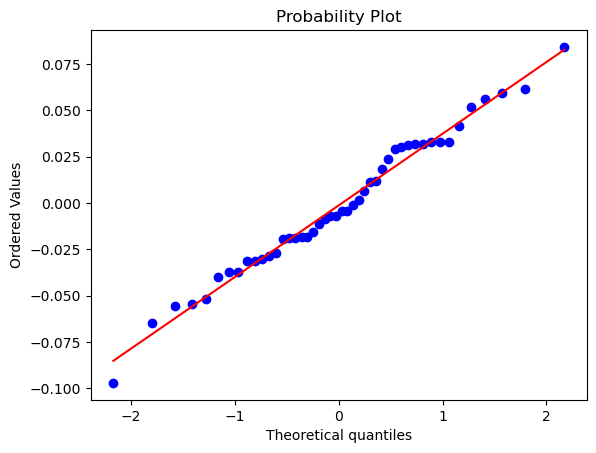

In [21]:
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(model.resid, dist="norm", plot=plt)
plt.show()


# Exercise 2
In a process for the production of metal laminates we collected 100 sequential measurements of laminate width (time series ‘A’ “Statistical Control by monitoring and feedback adjustment” Box Luceño – J. Wiley)


Identify and fit a model for the data.

<t1 style="color:red">
In a future class:
  
Design a SCC control chart and a FVC control chart  
</t1>


In [22]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_ex2.csv')

# Inspect the dataset
data.head()

EXE2
0    80
1    92
2   100
3    61
4    93

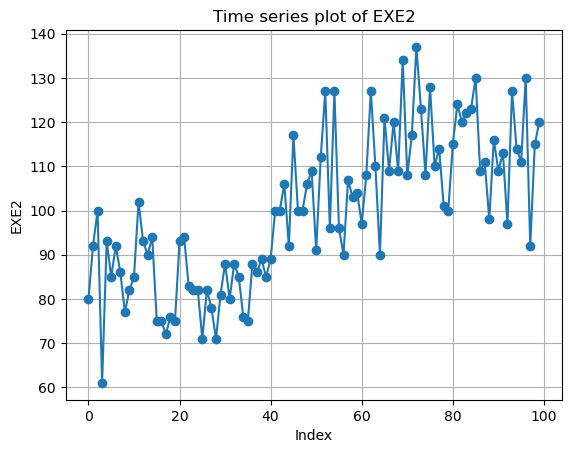

In [23]:
# Plot the data 
plt.plot(data['EXE2'], 'o-')
plt.xlabel('Index')
plt.ylabel('EXE2')
plt.title('Time series plot of EXE2')
plt.grid()
plt.show()

> let's verify the time dependence assumption with runs test and ACF/PACF

Runs test p-value = 0.000


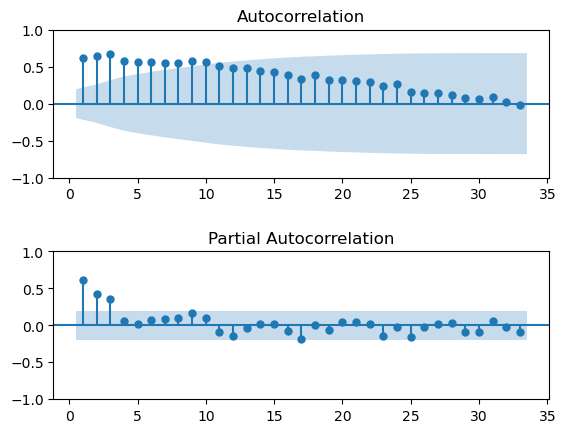

In [24]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['EXE2'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['EXE2'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['EXE2'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> The process is NON-STATIONARY.
>
> Let's try to apply the difference operator.

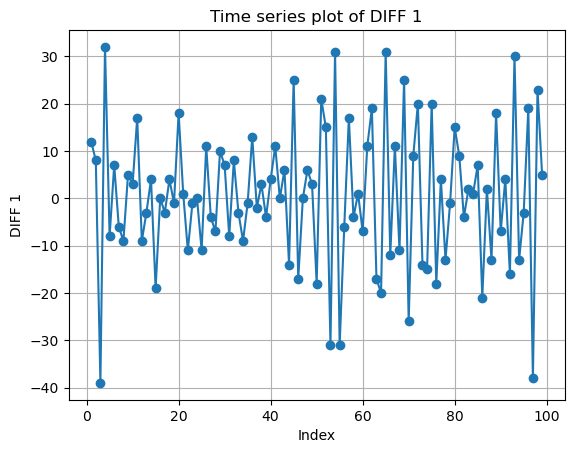

In [25]:
data['diff1'] = data['EXE2'].diff(1)

plt.plot(data['diff1'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF 1')
plt.title('Time series plot of DIFF 1')
plt.grid()
plt.show()

> Let's verify again the time dependence assumption with runs test and ACF/PACF on the DIFF1 data

Runs test p-value = 0.000


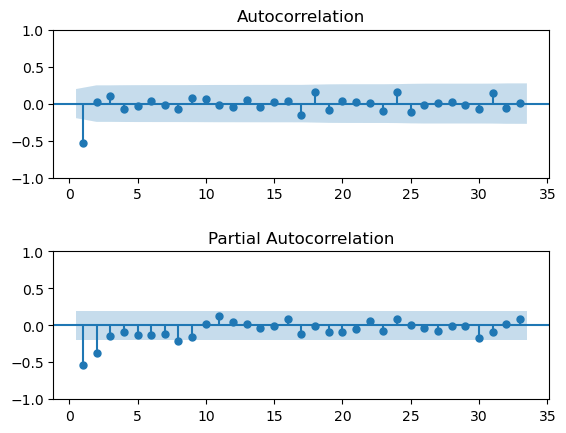

In [26]:
_, pval_runs = runstest_1samp(data['diff1'][1:], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> After the differencing operation, the most suitable model seems to be an MA(1). Thus the investigated model is ARIMA(0,1,1)

In [27]:
# calculate an ARIMA model: import the necessary library
import qda

> The function `qda.ARIMA()` requires as inputs:
> 1. The dataframe with the data.
> 2. The `order` parameter, i.e., the $(p, d, q)$ of the model: $AR(p)$, $I(d)$, $MA(q)$.
> 3. The `add_constant` parameter, i.e. the presence of a constant term in the model:
>    - `False`, for no constant term.
>    - `True`, for a constant term.

In [28]:
# fit model ARIMA with constant term
x = data['EXE2']
model = qda.ARIMA(x, order=(0,1,1), add_constant = True) 

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=1, q=1

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
const  0.3111    0.226   1.3765 1.6867e-01
ma.L1 -0.8143    0.064 -12.7215 4.4928e-37

RESIDUAL SUM OF SQUARES
-------------------------
  DF         SS       MS
97.0 12318.5893 126.9958

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      8.0673   0.7799
  24     14.9539   0.9221
  36     27.3625   0.8491
  48     39.2028   0.8133


> The calculated ARIMA model is in the form:
>
> $Y_t - Y_{t-1} = \nabla Y_t = \mu - \theta_{1}  \epsilon_{t-1} + \epsilon_t $
>
> The constant term ha a p-value of 0.169. Let's remove the constant value by setting the `add_constant` parameter to `False`.

In [29]:
# fit model ARIMA with constant term
x = data['EXE2']
model = qda.ARIMA(x, order=(0,1,1), add_constant=False) # ARIMA(p,d,q), no constant term

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=1, q=1

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
ma.L1 -0.7854   0.0626 -12.5422 4.3837e-36

RESIDUAL SUM OF SQUARES
-------------------------
  DF        SS       MS
98.0 12528.408 127.8409

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      8.5337   0.7422
  24     15.6625   0.8999
  36     27.8377   0.8329
  48     39.5483   0.8023


> The calculated ARIMA model is in the form:
>
> $Y_t - Y_{t-1} = \nabla Y_t = \theta_{1}  \epsilon_{t-1} + \epsilon_t $
>
> Let's check the assumptions on the residuals

Shapiro-Wilk test p-value = 0.643


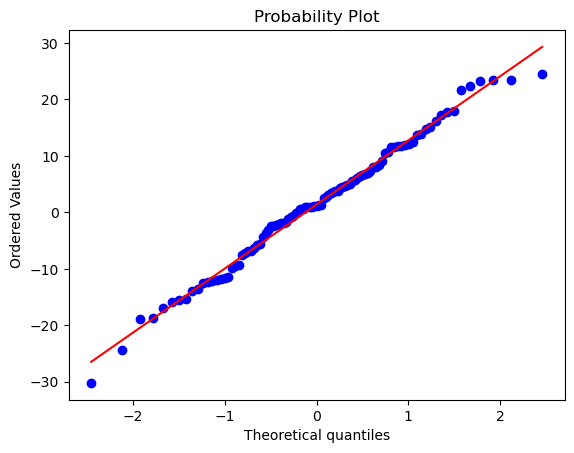

In [30]:
#extract the residuals
residuals = model.resid[1:]

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

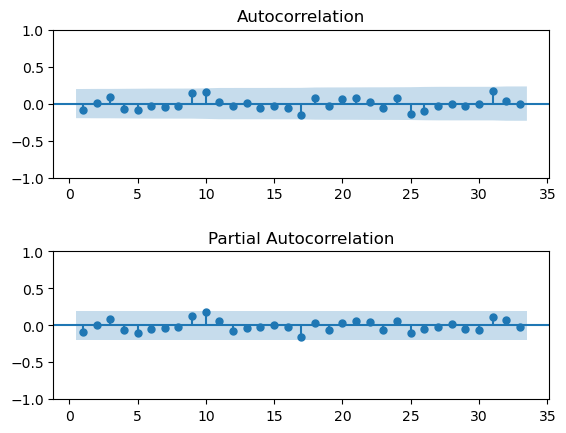

In [31]:
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

Try at home: Bartlett test and LBQ test on ARIMA model residuals

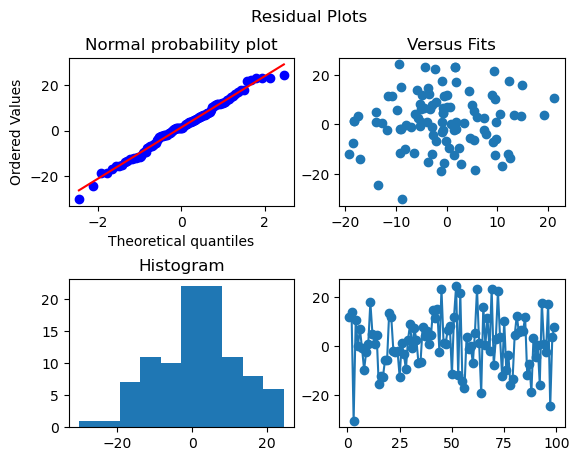

In [32]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues[1:], residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

> The model is adequate. 


# Exercise 3

In a chemical process, data related to the concentration of a given component are measured every two hours. 197 consecutive observations are stored in `ESE4_ex3.csv` (time series ‘A’ “Time Series Analysis – 3rd edition” Box Jenkins Reinsel – Prentice Hall)  


Estimate the most suitable ARIMA model.

In [33]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_ex3.csv')

# Inspect the dataset
data.head()

EXE3
0  17.0
1  16.6
2  16.3
3  16.1
4  17.1

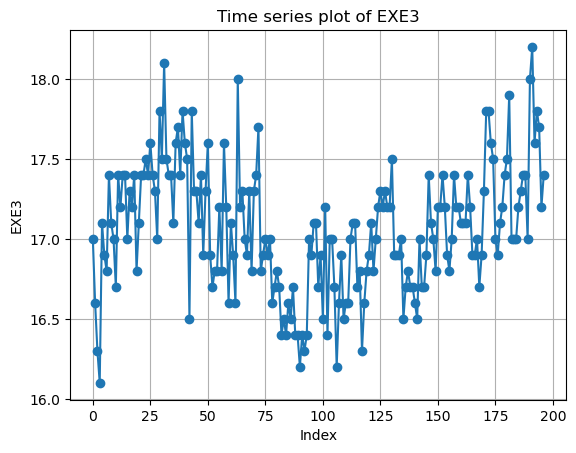

In [34]:
# Plot the data 
plt.plot(data['EXE3'], 'o-')
plt.xlabel('Index')
plt.ylabel('EXE3')
plt.title('Time series plot of EXE3')
plt.grid()
plt.show()

Runs test p-value = 0.000


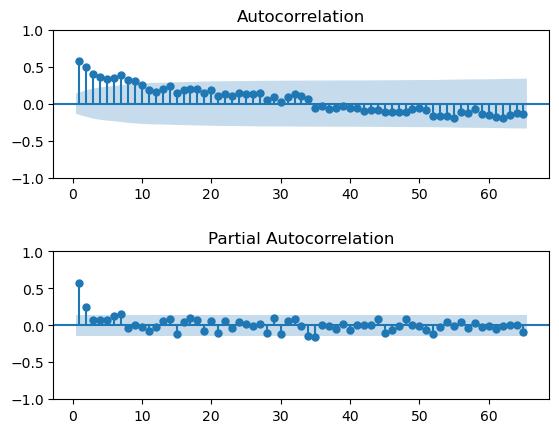

In [35]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['EXE3'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['EXE3'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['EXE3'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> The process is not stationary. Let's try to use the differencing operation

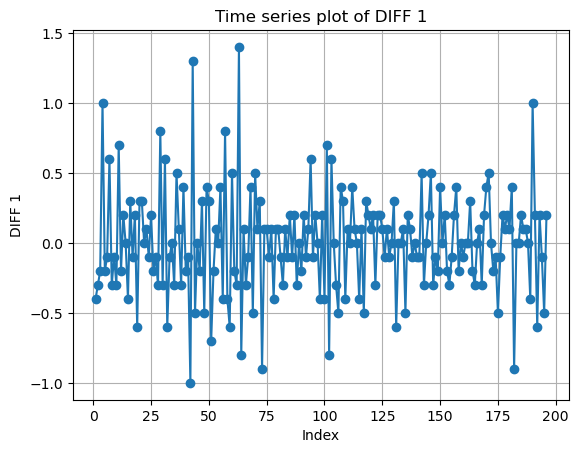

In [36]:
data['diff1'] = data['EXE3'].diff(1)

plt.plot(data['diff1'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF 1')
plt.title('Time series plot of DIFF 1')
plt.grid()
plt.show()

Runs test p-value = 0.003


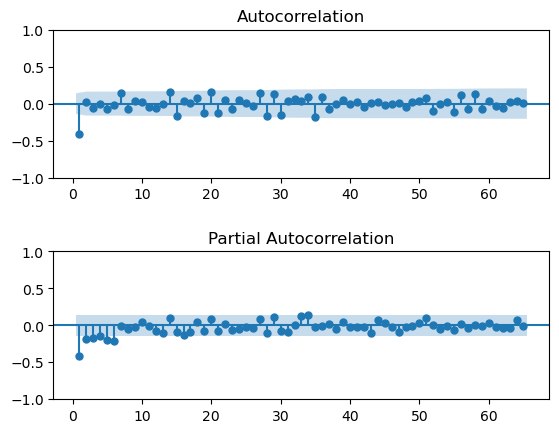

In [37]:
_, pval_runs = runstest_1samp(data['diff1'][1:], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> After the differencing operation and the ACF/PACF plots, we can try an ARIMA(0, 1, 1) model. Let's try to keep the constant term. 
> 
> <t1 style="color:red"> Remind: parsimony! </t1>

In [38]:
#calculate an ARIMA model: import the necessary library
import qda

# fit model ARIMA with constant term
model = qda.ARIMA(data['EXE3'], order=(0,1,1), add_constant=True)

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=1, q=1

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
const  0.0040   0.0069   0.5829 5.5998e-01
ma.L1 -0.7044   0.0581 -12.1304 7.2921e-34

RESIDUAL SUM OF SQUARES
-------------------------
   DF      SS     MS
194.0 19.8286 0.1022

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12     20.6433   0.0559
  24     32.2974   0.1198
  36     55.7981   0.0187
  48     60.5529   0.1055


> The constant term is not significant, remove it and fit the model again. 

In [ ]:
# fit model ARIMA without constant term
model = qda.ARIMA(data['EXE3'], order=(0,1,1), add_constant=False)

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=1, q=1

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
ma.L1 -0.6994   0.0576 -12.1454 6.0719e-34

RESIDUAL SUM OF SQUARES
-------------------------
   DF      SS     MS
195.0 19.8607 0.1018

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12     20.6672   0.0555
  24     32.3947   0.1175
  36     55.9565   0.0181
  48     60.6505   0.1040


> The calculated ARIMA model is in the form of an IMA(1,1):
>
> $$Y_t - Y_{t-1} = \nabla Y_t =  \theta_{1}  \epsilon_{t-1} + \epsilon_t $$
>
> Finally, check the assumptions on residuals

Shapiro-Wilk test p-value = 0.165


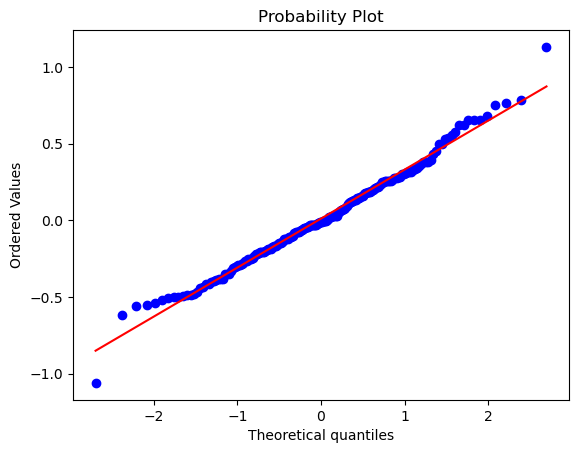

In [ ]:
#extract the residuals
residuals = model.resid[1:] 

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

Runs test p-value = 0.002


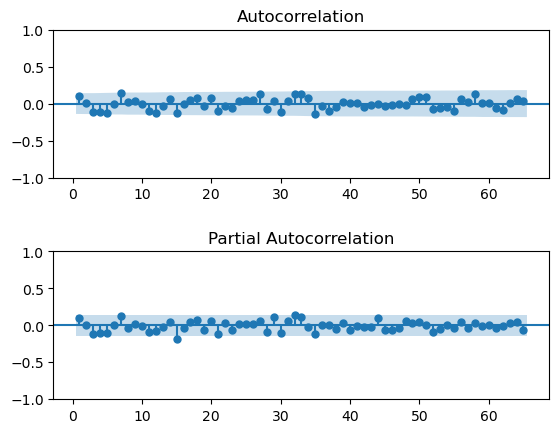

In [ ]:
_, pval_runs = runstest_1samp(residuals, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

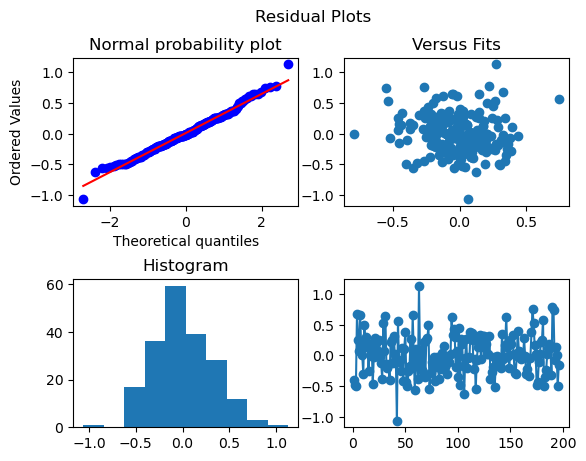

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues[1:], model.resid[1:])
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

## Fitting of a better model that doesn't fail the Runs and LBQ test

In [ ]:
import qda
# fit model ARIMA without constant term
p=6
d=1
q=0
model=qda.ARIMA(data['EXE3'],order=(p,d,q), add_constant=False)

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=6, d=1, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
ar.L1 -0.6208   0.0617 -10.0626 8.0875e-24
ar.L2 -0.4183   0.0928  -4.5054 6.6241e-06
ar.L3 -0.3795   0.0986  -3.8492 1.1851e-04
ar.L4 -0.3320   0.0958  -3.4644 5.3136e-04
ar.L5 -0.3367   0.0845  -3.9824 6.8226e-05
ar.L6 -0.2300   0.0730  -3.1500 1.6330e-03

RESIDUAL SUM OF SQUARES
-------------------------
   DF      SS     MS
190.0 17.5651 0.0924

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      4.8168   0.9638
  24     16.5615   0.8668
  36     36.9885   0.4231
  48     40.5602   0.7684


Shapiro-Wilk test p-value = 0.114


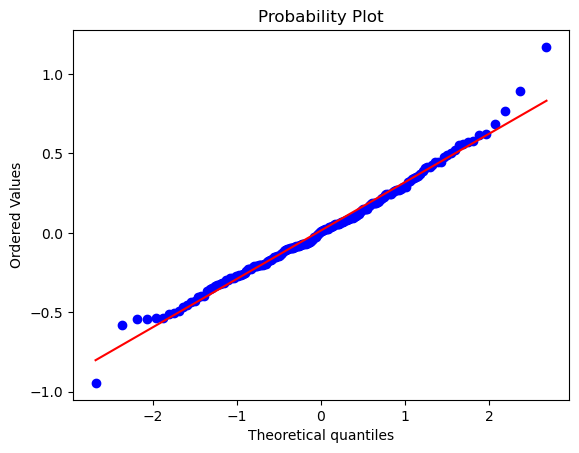

In [ ]:
#extract the residuals
residuals = model.resid[np.max((p,d,q)):] 

#extract the fitted values
fits = model.fittedvalues[np.max((p,d,q)):] 
 
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

Runs test p-value = 0.128


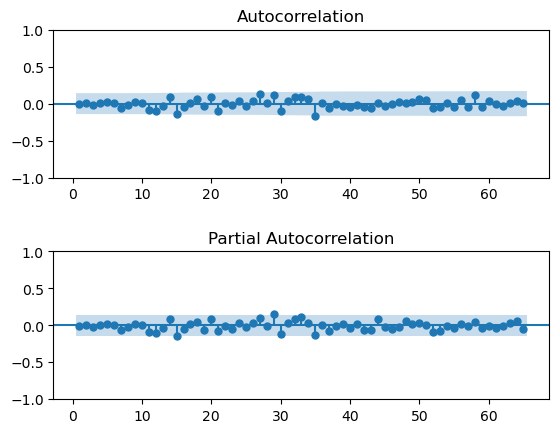

In [ ]:
_, pval_runs = runstest_1samp(residuals, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

The runs test gives a value higher than 0.05: the test is acceptable

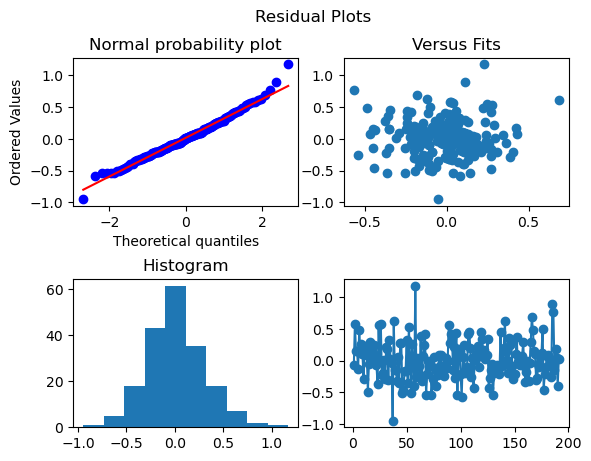

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(fits, residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

The model ARIMA(6,1,0) is adeguate


# Exercise 4

In a chemical process, 70 consecutive measurements were made over time for a given quality characteristic of interest. Data are stored in `ESE4_ex4.csv` (series ‘F’ “Time Series Analysis – 3rd edition” Box Jenkins Reinsel – Prentice Hall) 


Estimate the most suitable ARIMA model.

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_ex4.csv')

# Inspect the dataset
data.head()

EXE4
0    47
1    64
2    23
3    71
4    38

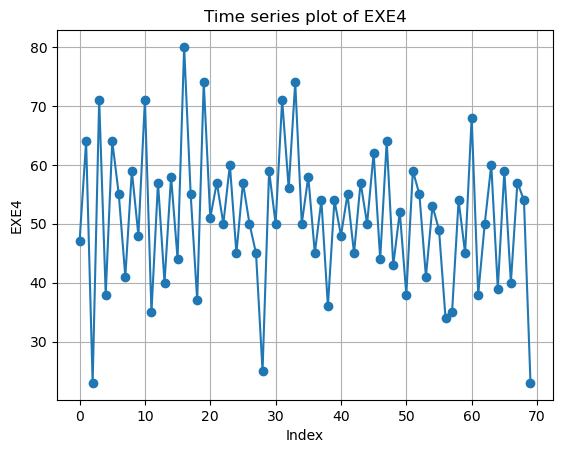

In [ ]:
# Plot the data 
plt.plot(data['EXE4'], 'o-')
plt.xlabel('Index')
plt.ylabel('EXE4')
plt.title('Time series plot of EXE4')
plt.grid()
plt.show()

> We observe a very high number of runs  
>
> <t1 style="color:red"> REMIND: typical pattern of negatively correlated process </t1>
>
> Systematic variation of observations above and below the mean

Runs test p-value = 0.000


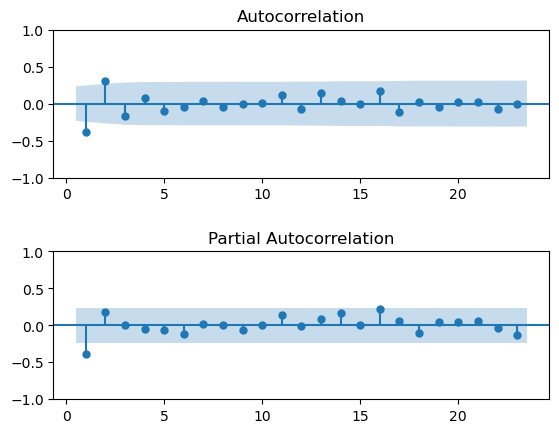

In [ ]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['EXE4'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['EXE4'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['EXE4'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> Some considerations:
> - It looks almost stationary
> - Geometric decay of ACF?
> - Most suitable model may be $AR(1)$ (with negative coeff.)

In [ ]:
#calculate an ARIMA model: import the necessary library
import qda

# fit model ARIMA with constant term
model = qda.ARIMA(data['EXE4'], order=(1,0,0), add_constant=True)

qda.ARIMAsummary(model)


---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=0, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value  P-Value
const 51.2662   0.9197  55.7451   0.0000
ar.L1 -0.4191   0.1206  -3.4748   0.0005

RESIDUAL SUM OF SQUARES
-------------------------
  DF        SS       MS
68.0 8147.0993 119.8103

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      6.5548   0.8856
  24     17.7915   0.8130
  36     23.2315   0.9506
  48     32.1413   0.9618


> The calculated ARIMA model is:
>
> $X_t =  51.2662 - 0.41491 X_{t-1} + \epsilon_t $
>
> Finally, check the assumptions on residuals

Shapiro-Wilk test p-value = 0.279


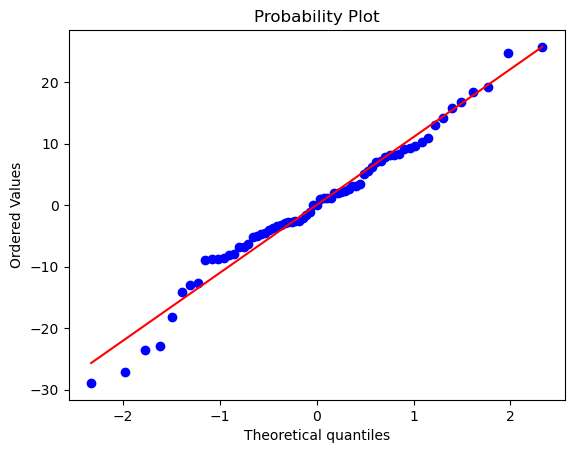

In [ ]:
#extract the residuals
residuals = model.resid[1:] 

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

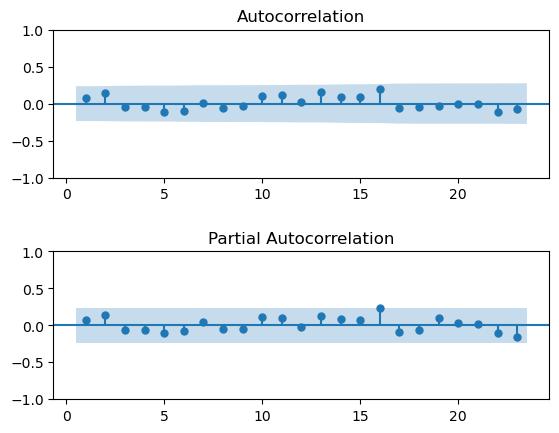

In [ ]:
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

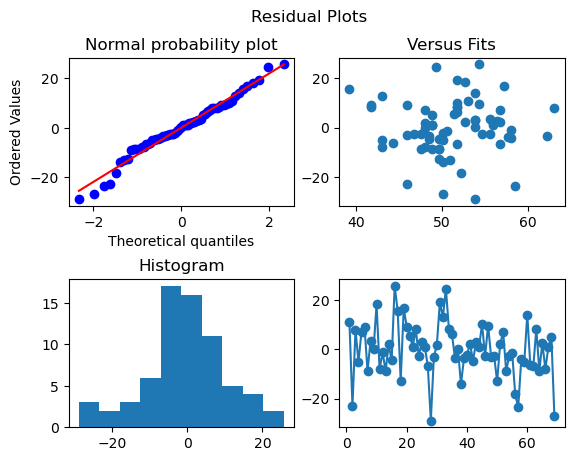

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues[1:], model.resid[1:])
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

> The model is adequate.
>
> The implementation of an $AR(1)$ can be done also solved with a linear regression, using as regressor the LAG1 of the series.

In [ ]:
#calculate a regression model with constant and lag1
data['lag1'] = data['EXE4'].shift(1)

import statsmodels.api as sm

x = data['lag1'][1:]
x = sm.add_constant(data['lag1'][1:]) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data['EXE4'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
EXE4 =  + 73.086 const -0.425 lag1

COEFFICIENTS
------------
 Term    Coef  SE Coef  T-Value    P-Value
const 73.0863   6.1411  11.9013 3.4846e-18
 lag1 -0.4249   0.1163  -3.6522 5.1101e-04

MODEL SUMMARY
-------------
      S  R-sq  R-sq(adj)
11.0269 0.166     0.1536

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value    P-Value
Regression  1.0  1621.8423  1621.8423  13.3383 5.1101e-04
     const  1.0 17222.3684 17222.3684 141.6399 3.4846e-18
      lag1  1.0  1621.8423  1621.8423  13.3383 5.1101e-04
     Error 67.0  8146.7084   121.5927      NaN        NaN
     Total 68.0  9768.5507        NaN      NaN        NaN


Shapiro-Wilk test p-value on the residuals = 0.271
Runs test p-value on the residuals = 0.543


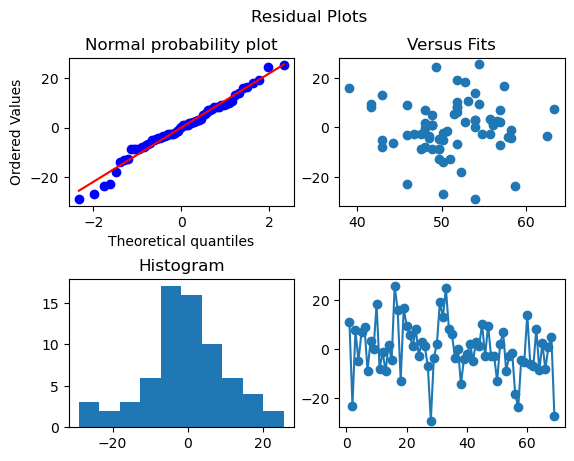

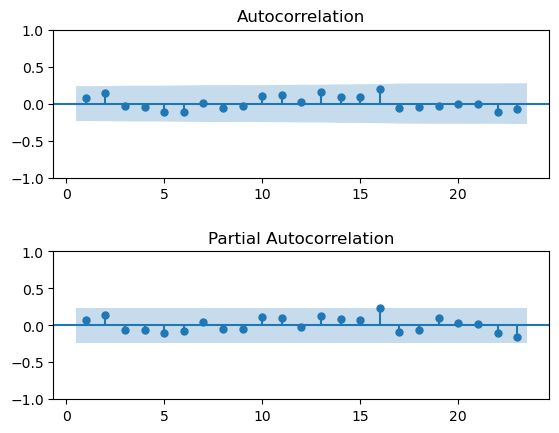

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
fig.subplots_adjust(hspace=0.5)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

# Runs test and ACF/PACF
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> <h3 style="color:red">Notice:</h3>
>
> The coefficients of the AR(1) model fitted with ARIMA command are slightly different from the ones of the same model fitted with ordinary least squares because two different solvers are used.
>
> <h3 style="color:red"> Remind that: </h3> 
> 'All models are wrong, but some are useful' (George E. P. Box)

<h1 style="color:orange">EXERCISE CLASS 4 - Additional Excercises</h1>

# Additional exercise 1

In a shop floor, the head of the quality assurance department is interested in keeping under control the stability of a turning process.
Every day, the cylindrical rings are produced in four temporally consecutive batches denoted as A (early morning), B (late morning), C (early afternoon), D (late afternoon).
One cylindrical ring is collected and its outer diameter (cm) is measured every day in each batch.
A dataset consisting of 25 consecutive sample collections is stored in 'ESE4_add_ex1.csv'.
Identify a suitable model.

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_add_ex1.csv')

# Inspect the dataset
data.head()

Diameter
0      2.92
1      2.90
2      4.07
3      3.09
4      3.63

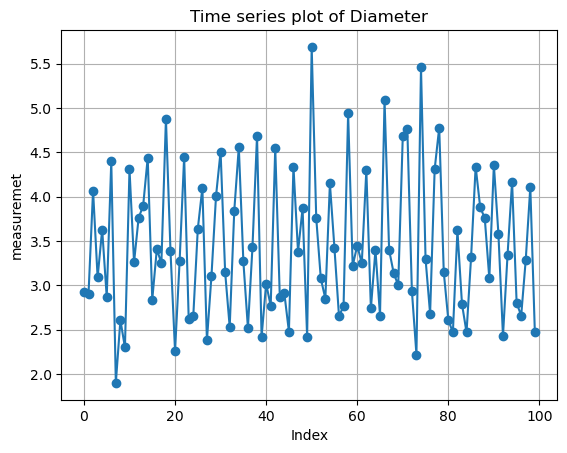

In [ ]:
# Plot the data 
plt.plot(data['Diameter'], 'o-')
plt.xlabel('Index')
plt.ylabel('measuremet')
plt.title('Time series plot of Diameter')
plt.grid()
plt.show()

Runs test p-value = 0.094


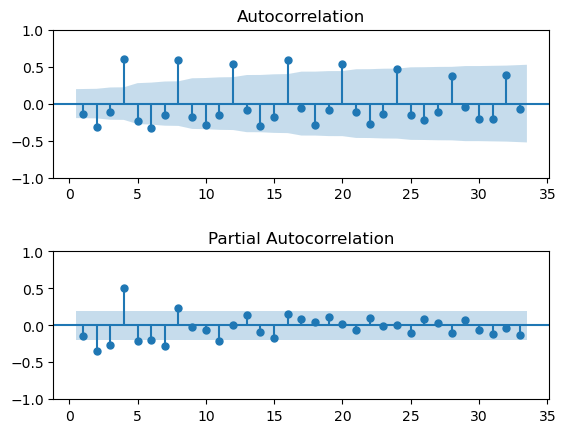

In [ ]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['Diameter'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['Diameter'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['Diameter'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> Runs test would lead to not reject the randmness assumption at 95% confidence, but the time series exhibits a clear pattern.

> <t1 style="color:red"> Batch effect? </t1>

> Let's create DAY and BATCH variables

In [ ]:
# Create Batch variable
data['Batch'] = np.tile(np.arange(1, 5), int(len(data)/4)) #tile the simple batches array ([1 2 3 4]) for 25 times
data['Day'] = np.repeat(np.arange(1, len(data)/4+1), 4) #repeate the element of the days array [from 1 to 25] for time each element

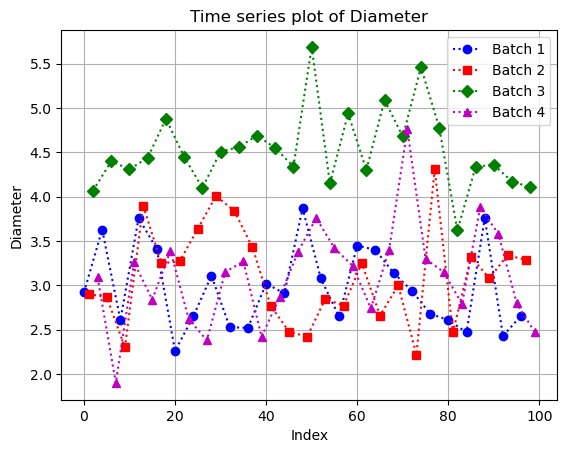

In [ ]:
# Plot the data as 4 separate batches
#we need to extract the data for each batch; change the color, the line, and the marker; assign a label for each batch

plt.plot(data['Diameter'][data['Batch'] == 1], 'o:b', label = 'Batch 1') 
plt.plot(data['Diameter'][data['Batch'] == 2], 's:r', label = 'Batch 2')
plt.plot(data['Diameter'][data['Batch'] == 3], 'D:g', label = 'Batch 3')
plt.plot(data['Diameter'][data['Batch'] == 4], '^:m', label = 'Batch 4')

plt.xlabel('Index')
plt.ylabel('Diameter')
plt.legend()
plt.title('Time series plot of Diameter')
plt.grid()
plt.show()

> <t1 style="color:red"> Batch 3 yields systematically a larger diameter than the other batches. </t1>

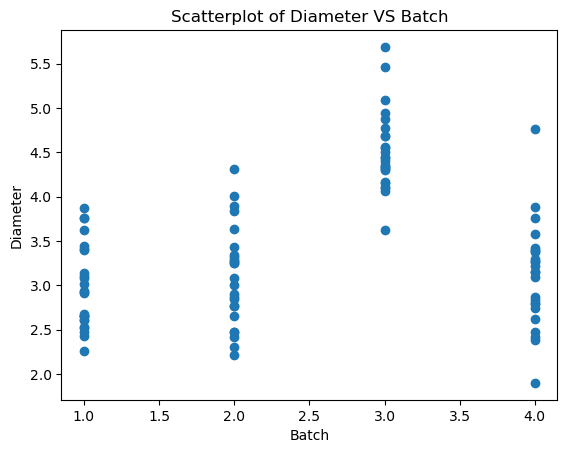

In [ ]:
#Other possible graphs: scatterplot of Diameter VS batch
plt.scatter(data['Batch'], data['Diameter'])
plt.xlabel('Batch')
plt.ylabel('Diameter')
plt.title('Scatterplot of Diameter VS Batch')
plt.show()

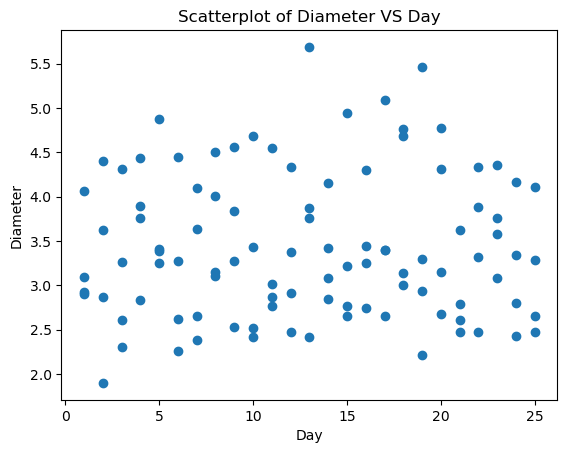

In [ ]:
#Other possible graphs: scatterplot of Diameter VS day
plt.scatter(data['Day'], data['Diameter'])
plt.xlabel('Day')
plt.ylabel('Diameter')
plt.title('Scatterplot of Diameter VS Day')
plt.show()

> # Which type of model?  
> Dummy variable:
> - =0 for batches A, B and D
> - =1 for batch C

In [ ]:
# create the dummy variable 
data['Dummy'] = np.tile(np.array([0, 0, 1, 0]), int(len(data)/4))


In [ ]:
#calculate a regression model with constant and dummy
import statsmodels.api as sm
import qda

x = data['Dummy']
x = sm.add_constant(data['Dummy']) 
y = data['Diameter']
model = sm.OLS(y, x).fit()

qda.summary(model)

REGRESSION EQUATION
-------------------
Diameter =  + 3.066 const + 1.454 Dummy

COEFFICIENTS
------------
 Term   Coef  SE Coef  T-Value    P-Value
const 3.0660   0.0591  51.8649 4.6112e-73
Dummy 1.4536   0.1182  12.2947 1.4247e-21

MODEL SUMMARY
-------------
    S   R-sq  R-sq(adj)
0.512 0.6067     0.6027

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS   F-Value    P-Value
Regression  1.0  39.6179  39.6179  151.1585 1.4247e-21
     const  1.0 705.0267 705.0267 2689.9677 4.6112e-73
     Dummy  1.0  39.6179  39.6179  151.1585 1.4247e-21
     Error 98.0  25.6853   0.2621       NaN        NaN
     Total 99.0  65.3032      NaN       NaN        NaN


Shapiro-Wilk test p-value on the residuals = 0.149


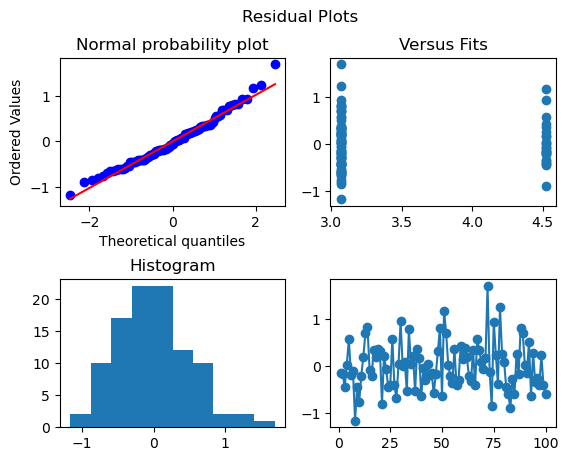

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

Runs test p-value on the residuals = 0.699


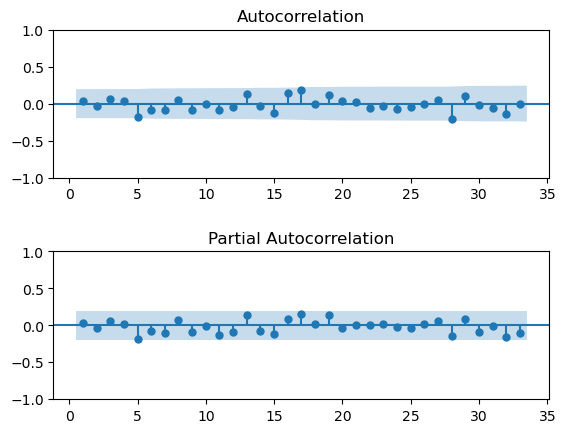

In [ ]:
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> The model is adequate: Residuals and normal and independent.

> What if we used a diffrent dummy variable definition?  
> Let's try to use the Batch variable as a set of categorical dummy variables.

In [ ]:
#create a vectors for dummy variables associated to each batch
data['Dummy_Batch1'] = np.where(data['Batch']==1, 1, 0)
data['Dummy_Batch2'] = np.where(data['Batch']==2, 1, 0)
data['Dummy_Batch3'] = np.where(data['Batch']==3, 1, 0)
data['Dummy_Batch4'] = np.where(data['Batch']==4, 1, 0)

x = data[['Dummy_Batch1', 'Dummy_Batch2', 'Dummy_Batch3', 'Dummy_Batch4']]
x = sm.add_constant(x) 
y = data['Diameter']
model = sm.OLS(y, x).fit()

qda.summary(model)

REGRESSION EQUATION
-------------------
Diameter =  + 2.744 const + 0.235 Dummy_Batch1 + 0.362 Dummy_Batch2 + 1.776 Dummy_Batch3 + 0.370 Dummy_Batch4

COEFFICIENTS
------------
        Term   Coef  SE Coef  T-Value    P-Value
       const 2.7435   0.0411  66.6718 3.3063e-82
Dummy_Batch1 0.2353   0.0897   2.6234 1.0126e-02
Dummy_Batch2 0.3621   0.0897   4.0373 1.0877e-04
Dummy_Batch3 1.7761   0.0897  19.8039 1.1292e-35
Dummy_Batch4 0.3701   0.0897   4.1265 7.8447e-05

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.5171 0.6111     0.5989

ANALYSIS OF VARIANCE
---------------------
      Source   DF    Adj SS    Adj MS   F-Value    P-Value
  Regression  3.0   39.9038   13.3013   50.2738 1.2792e-19
       const  1.0 1176.0784 1176.0784 4445.1343 3.3063e-82
Dummy_Batch1  1.0    1.8209    1.8209    6.8825 1.0126e-02
Dummy_Batch2  1.0    4.3126    4.3126   16.2999 1.0877e-04
Dummy_Batch3  1.0  103.7651  103.7651  392.1932 1.1292e-35
Dummy_Batch4  1.0    4.5052    4.5052   17.0281 7.84

Shapiro-Wilk test p-value on the residuals = 0.178
Runs test p-value on the residuals = 0.971


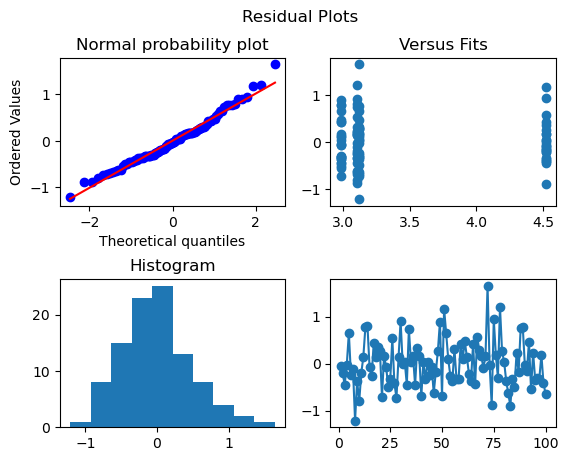

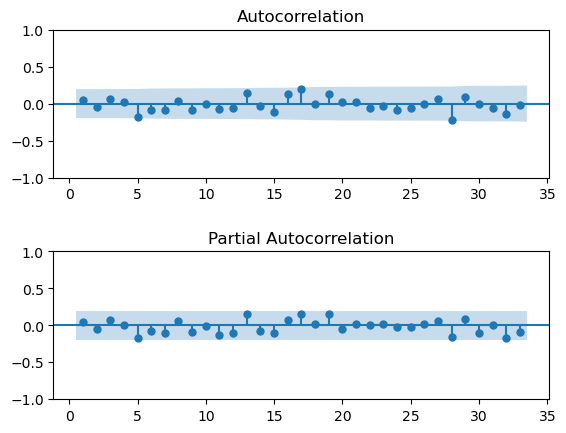

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> The model is similar, with an R-squared adjusted of 0.599 (against the previous of 0.603).

# Additional exercise 2
A scientific instrument installed on the International Space Station is kept at a low temperature by means of a liquid cooling system. The average temperature measured every day for 40 consecutive days are reported in 'ESE4_add_ex2.csv'. From day 18 to day 22 the instrument was used for some extra experiments, whereas normal operating conditions were applied in all the remaining days.  

Identify a suitable model.

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Import the dataset
data = pd.read_csv('ESE4_add_ex2.csv')

# Inspect the dataset
data.head()

Temp
0  6.00
1  5.80
2  6.10
3  5.15
4  5.02

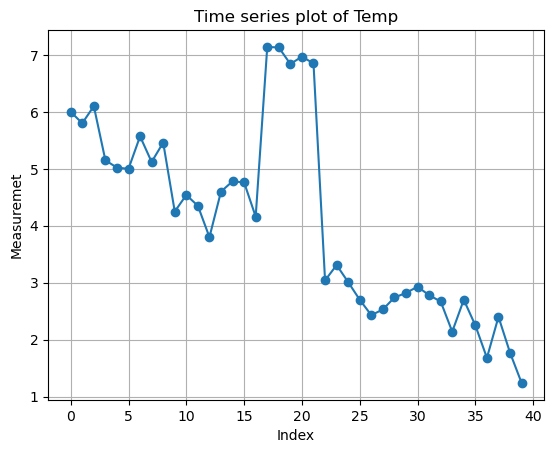

In [ ]:
# Plot the data 
plt.plot(data['Temp'], 'o-')
plt.xlabel('Index')
plt.ylabel('Measuremet')
plt.title('Time series plot of Temp')
plt.grid()
plt.show()

Runs test p-value = 0.000


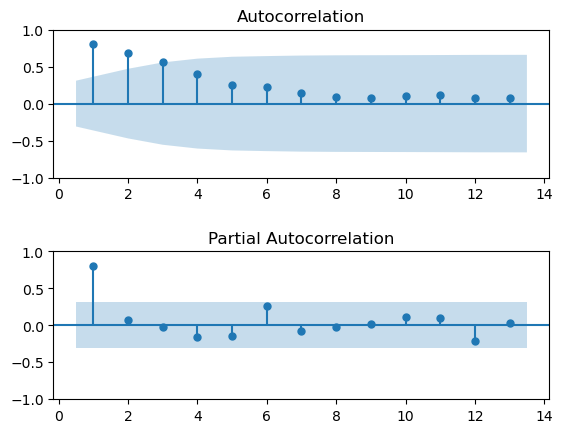

In [ ]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['Temp'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['Temp'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['Temp'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> There is a trend, with a jump in the middle for days 18-22.

> Let's try to fit a model with a dummy variable that is non-null just for days 18-22. Create a model in the form:

> $$ X_t = \beta_0 + \beta_1 day + \beta_2 𝑑𝑢𝑚𝑚𝑦+ \epsilon_t $$

In [ ]:
#create dummy variable
data['dummy'] = np.zeros(len(data))
data['dummy'][17:22] = 1

#create day of week variable
data['Day'] = np.arange(1, len(data)+1)

In [ ]:
import statsmodels.api as sm
import qda

x = data[['Day', 'dummy']]
x = sm.add_constant(x) 
y = data['Temp']
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
Temp =  + 5.886 const -0.106 Day + 3.222 dummy

COEFFICIENTS
------------
 Term    Coef  SE Coef  T-Value    P-Value
const  5.8865   0.1175  50.1108 1.3022e-35
  Day -0.1061   0.0049 -21.6762 1.2642e-22
dummy  3.2225   0.1709  18.8533 1.4522e-20

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.3575 0.9578     0.9555

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS   F-Value    P-Value
Regression  2.0 107.1974  53.5987  419.4561 3.7689e-26
     const  1.0 320.8704 320.8704 2511.0885 1.3022e-35
       Day  1.0  60.0391  60.0391  469.8581 1.2642e-22
     dummy  1.0  45.4197  45.4197  355.4482 1.4522e-20
     Error 37.0   4.7279   0.1278       NaN        NaN
     Total 39.0 111.9253      NaN       NaN        NaN


Shapiro-Wilk test p-value on the residuals = 0.326
Runs test p-value on the residuals = 0.112


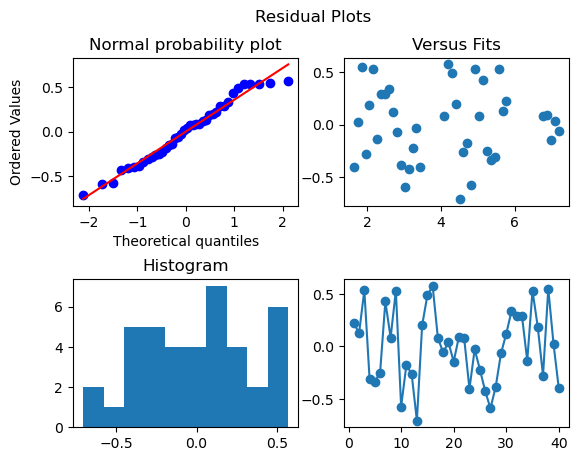

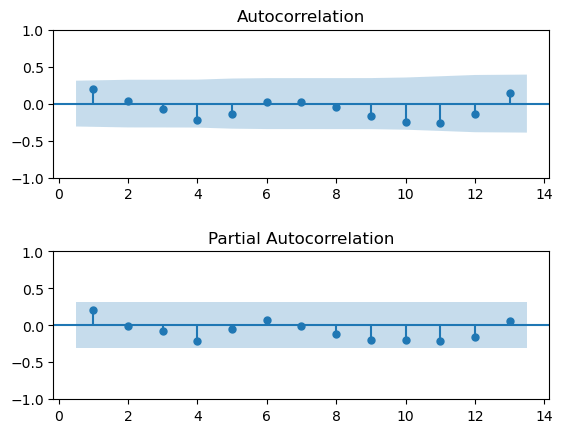

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

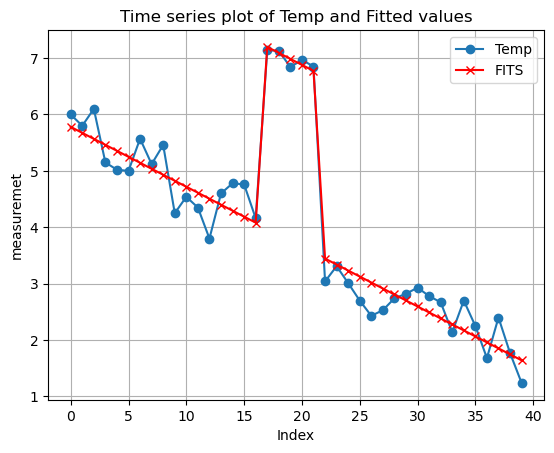

In [ ]:
# Plot the data 
plt.plot(data['Temp'], 'o-', label = 'Temp')
plt.plot(model.fittedvalues, 'x-r', label = 'FITS')
plt.xlabel('Index')
plt.ylabel('measuremet')
plt.legend()
plt.title('Time series plot of Temp and Fitted values')
plt.grid()
plt.show()